In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json

from rich import print
from python.analysis import Master, BeamParticleSelection, PFOSelection, Plots, shower_merging, vector, Tags, cross_section, EventSelection

import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from particle import Particle
from scipy.optimize import curve_fit


shower_merging.SetPlotStyle(extend_colors = True, dpi = 140)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
config = "work/2023/cex_analysis_2GeV_config.json"
if not config:
    mc = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)
    data = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root", nTuple_type = Master.Ntuple_Type.PDSP)

    beam_quality_fits = {
        "mc" : "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03_fit_values.json",
        "data" : "work/2023/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01_fit_values.json"
    }
else:
    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    mc = Master.Data(args.mc_file, nTuple_type = Master.Ntuple_Type.PDSP)
    data = Master.Data(args.data_file, nTuple_type = Master.Ntuple_Type.PDSP)
    beam_quality_fits = {"mc" : args.mc_beam_quality_fit, "data" : args.data_beam_quality_fit}

samples = {"mc" : mc, "data": data}


for f in beam_quality_fits:
    with open(beam_quality_fits[f], "r") as file:
        beam_quality_fits[f] = json.load(file)

def FilterSamples(samples : dict, masks : dict, PFO : bool = False):
    for s in samples:
        if PFO:
            samples[s].Filter([masks[s]])
        else:
            samples[s].Filter([masks[s]], [masks[s]])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1126: RuntimeWarning: invalid value encountered in divide
  h_mc = np.sum(h_mc, axis = 0)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1127: RuntimeWarning: invalid value encountered in divide
  


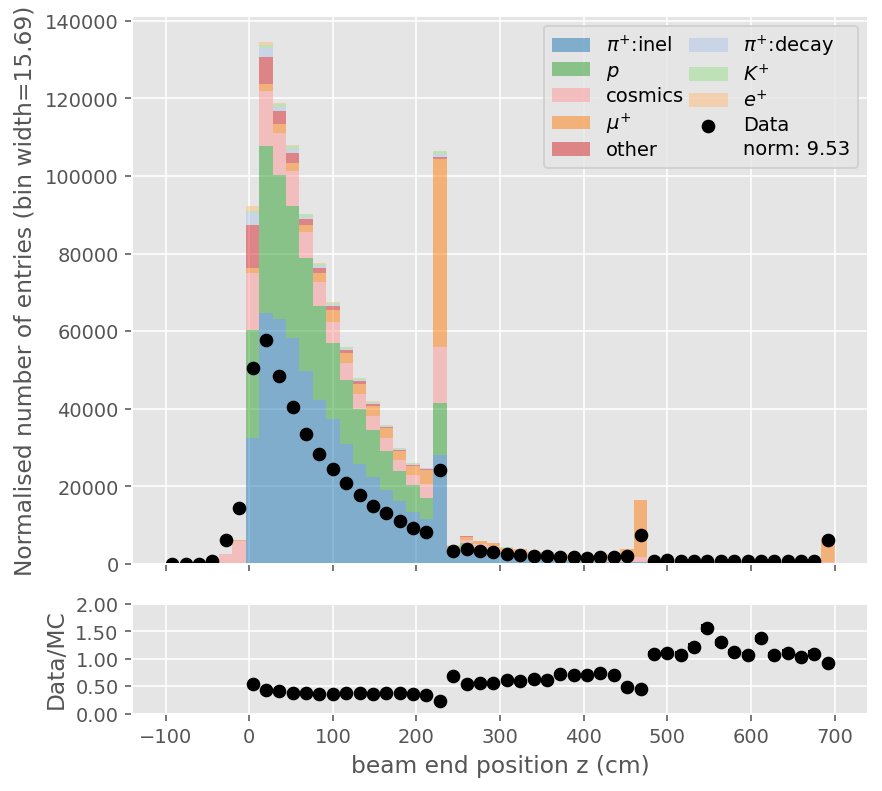

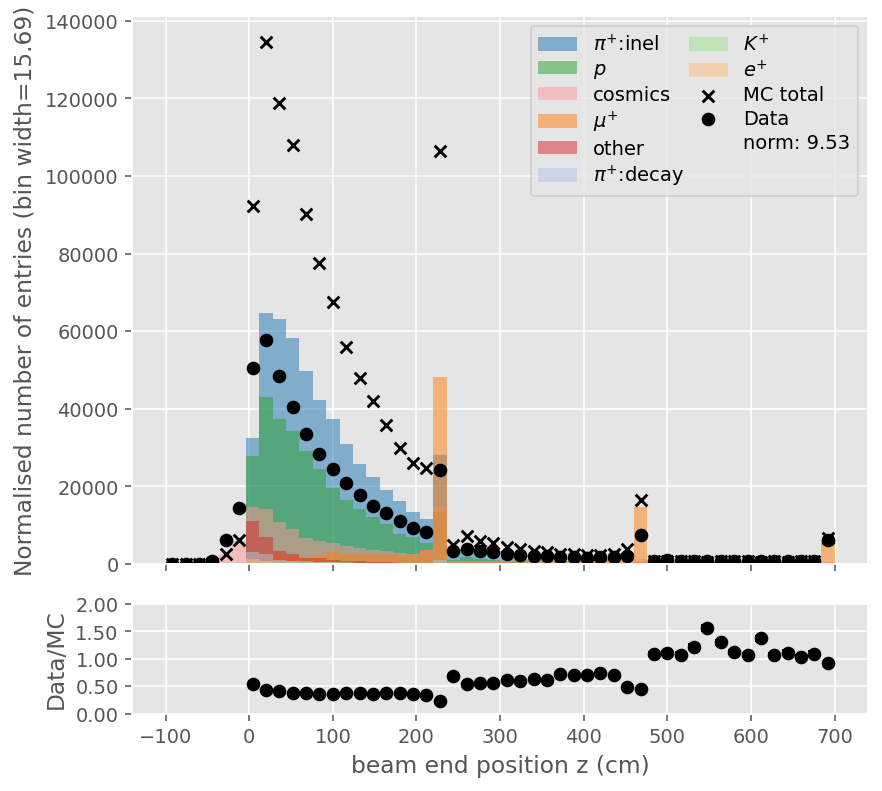

In [42]:
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = True, alpha = 0.5)
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = False, alpha = 0.5)
# Plots.PlotTagged(mc.trueParticles.endPos.z[:, 0], Tags.GenerateTrueBeamParticleTags(mc), x_range = [-100, 700], norm = True, bins = 50, x_label = "true beam end position z (cm)")

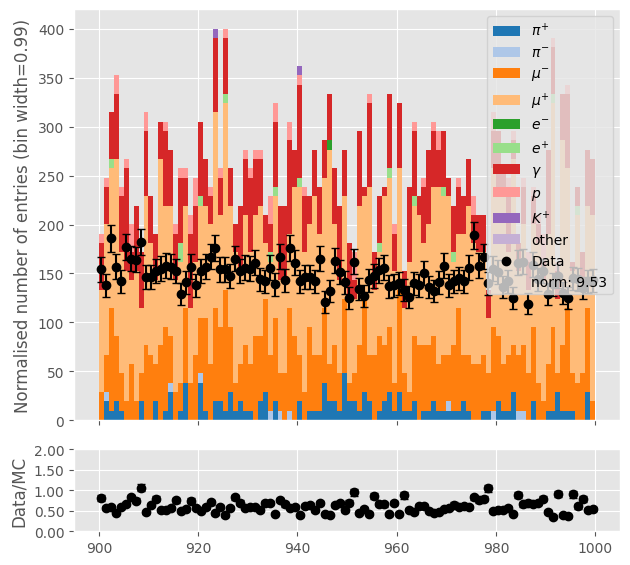

In [5]:
event_normalisation = ak.count(data.eventNum) / ak.count(mc.eventNum)
pfo_normalisation = ak.count(data.recoParticles.number) / ak.count(mc.recoParticles.number)
Plots.PlotTagged(mc.recoParticles.energy, Tags.GenerateTrueParticleTags(mc), data2 = data.recoParticles.energy, y_scale = "linear", norm = event_normalisation, x_range = [900, 1000])

# Beam Particle Selection

number of entries before|after PiBeamSelection: 141548|102443
number of entries before|after PiBeamSelection: 1349399|285238


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


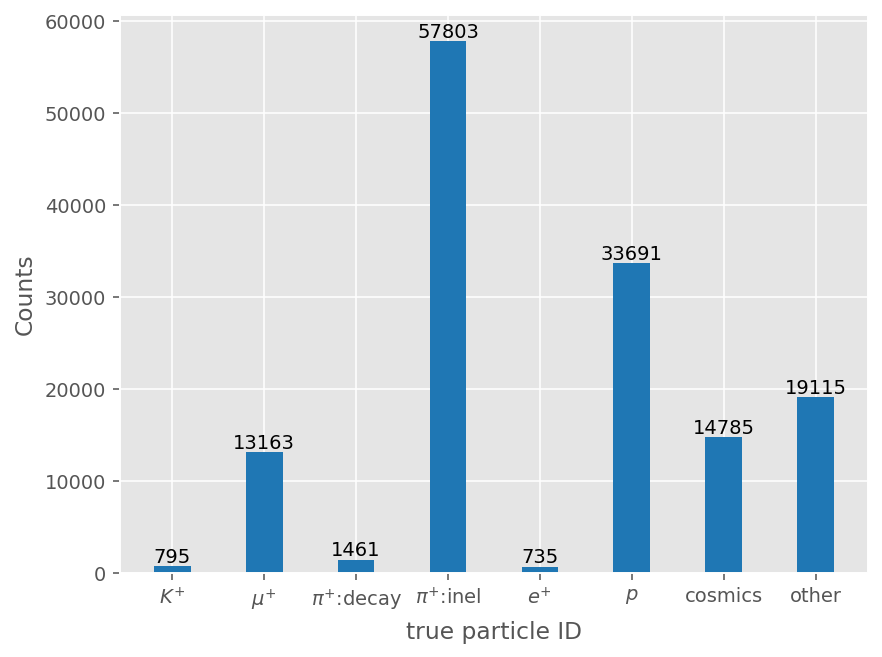

In [19]:
masks = {
    "mc" : BeamParticleSelection.PiBeamSelection(samples["mc"]),
    "data" : BeamParticleSelection.PiBeamSelection(samples["data"], use_beam_inst = True)
}

counts = Tags.GenerateTrueBeamParticleTags(samples["mc"])
for i in counts:
    counts[i] = ak.sum(counts[i].mask)

bar_data = []
for tag in counts:
    bar_data.extend([tag]*counts[tag])
Plots.PlotBar(bar_data, xlabel = "true particle ID")

FilterSamples(samples, masks)

In [20]:
masks = {s : BeamParticleSelection.CaloSizeCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

number of entries before|after CaloSizeCut: 102443|91248
number of entries before|after CaloSizeCut: 285238|248398


number of entries before|after PandoraTagCut: 91248|87403
number of entries before|after PandoraTagCut: 248398|232423


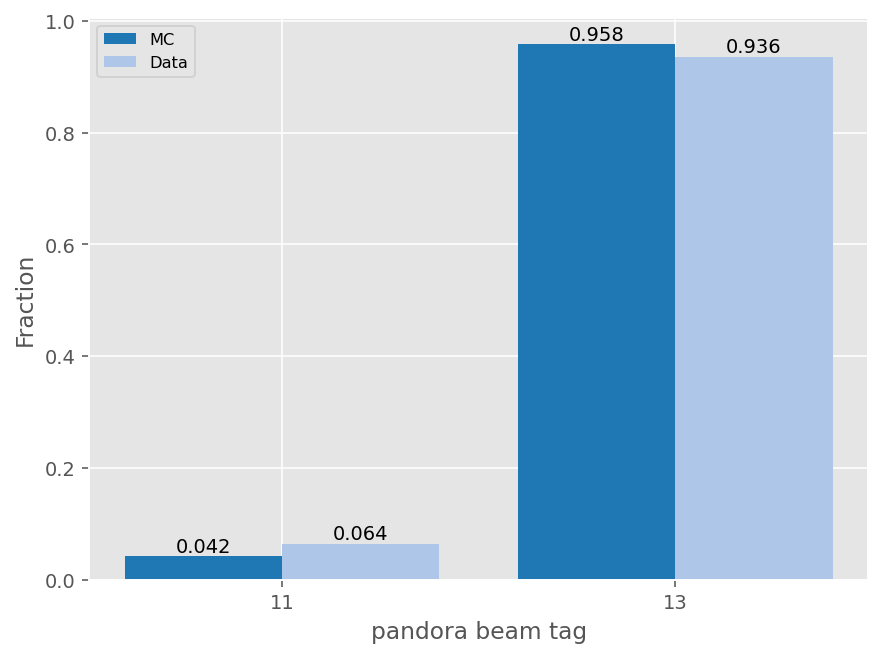

In [21]:
masks = {s : BeamParticleSelection.PandoraTagCut(samples[s]) for s in samples}

if data is None:
    Plots.PlotBar(samples["mc"])
else:
    Plots.PlotBarComparision(samples["mc"].recoParticles.beam_pandora_tag, samples["data"].recoParticles.beam_pandora_tag, label_1 = "MC", label_2 = "Data", xlabel = "pandora beam tag", fraction = True, barlabel = True)

FilterSamples(samples, masks)

dxy cut: (87403, 68150)

dxy cut: (232423, 181810)

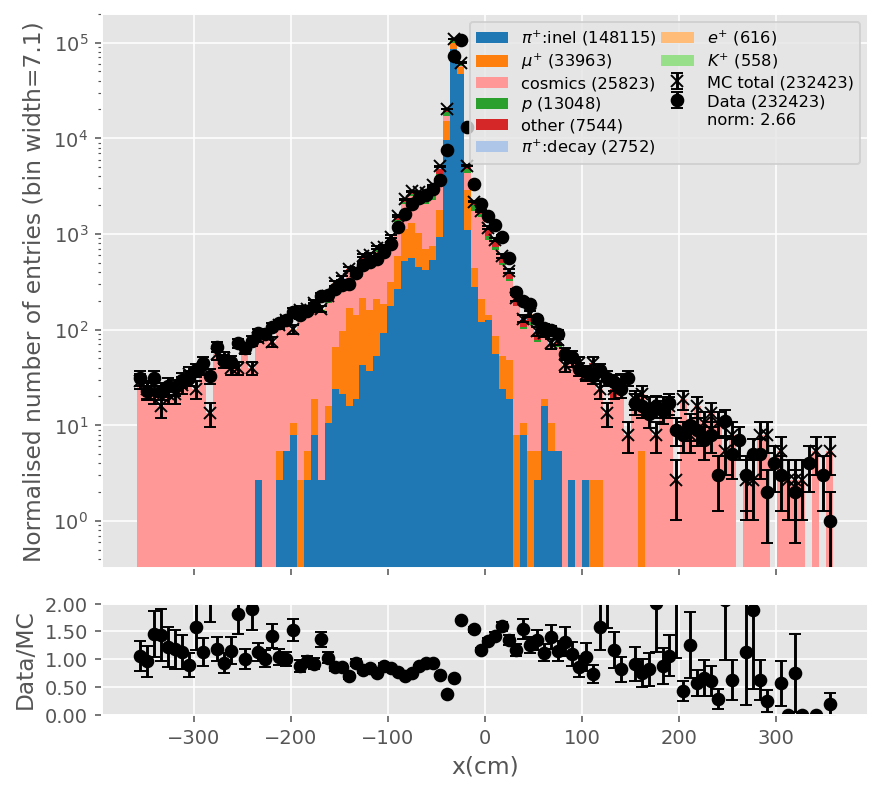

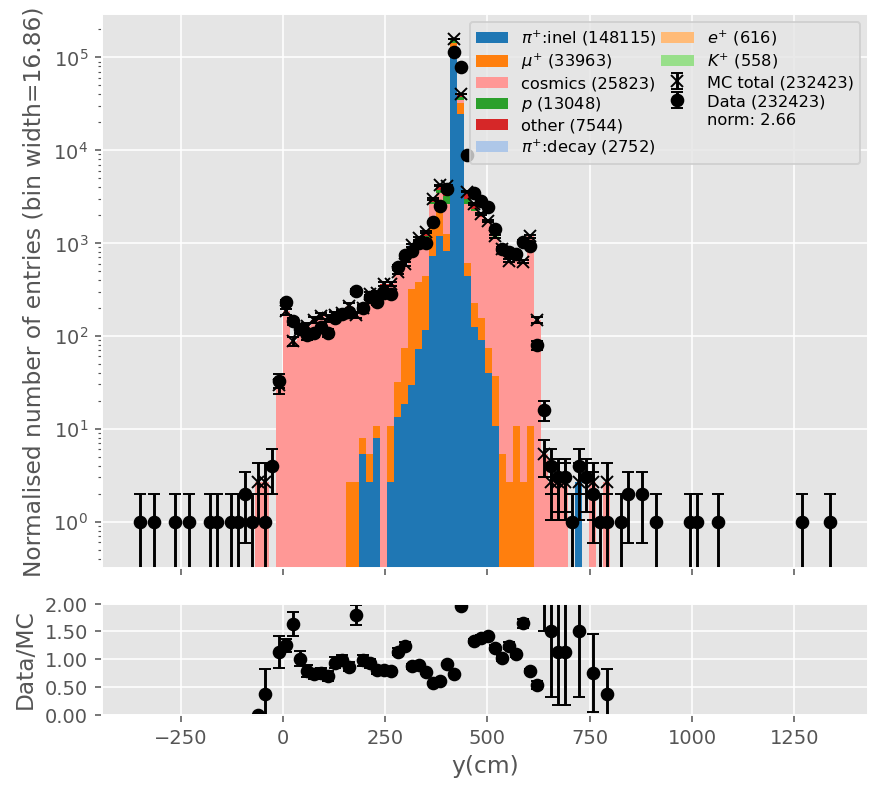

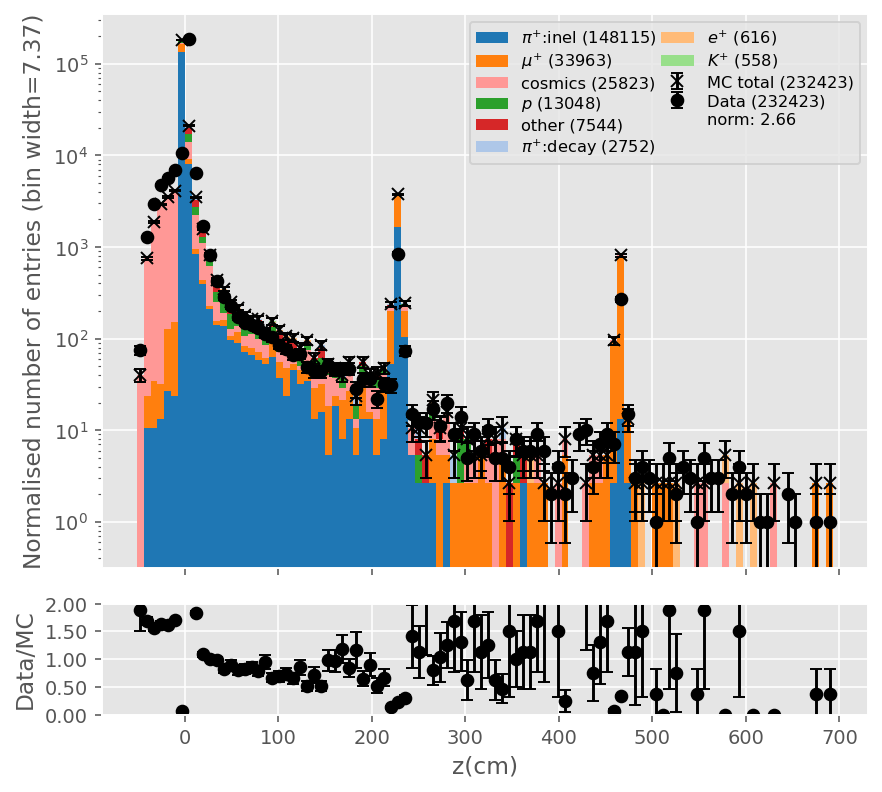

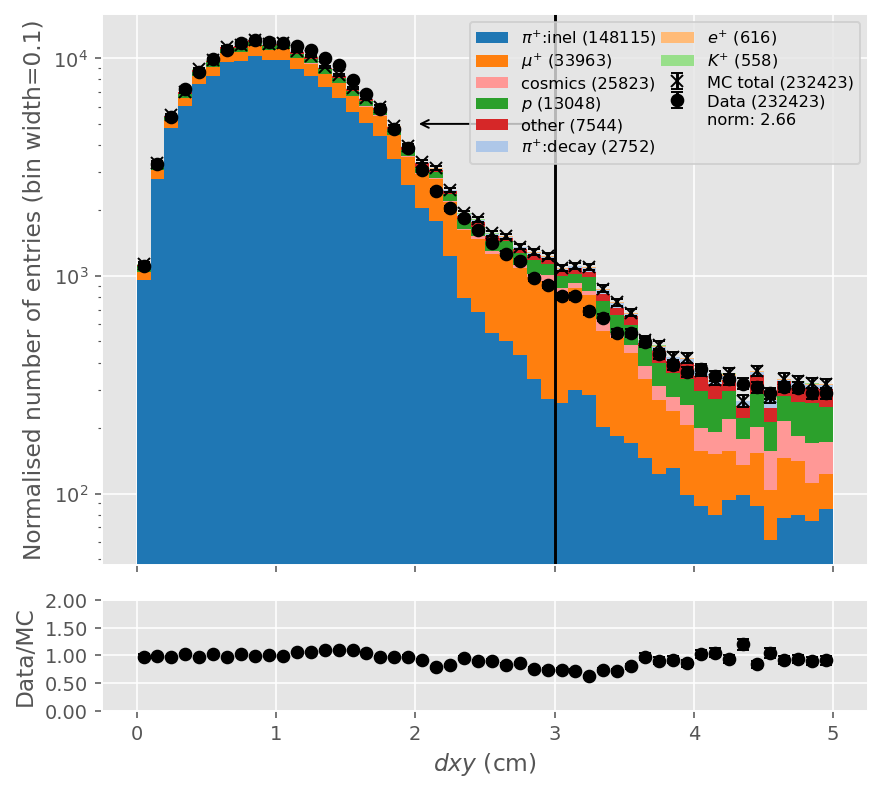

In [23]:
def norm(x, mu, sigma):
    return (x - mu) / sigma

# Beam quality cuts
for i in ["x", "y", "z"]:
    Plots.PlotTagged(mc.recoParticles.beam_startPos_SCE[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_startPos_SCE[i], x_label = i + "(cm)", y_scale = "log", norm = True)

#* dxy cut
dxy = {s : (norm(samples[s].recoParticles.beam_startPos_SCE.x, beam_quality_fits[s]["mu_x"], beam_quality_fits[s]["sigma_x"])**2 + norm(samples[s].recoParticles.beam_startPos_SCE.y, beam_quality_fits[s]["mu_y"], beam_quality_fits[s]["sigma_y"])**2)**0.5 for s in samples}
masks = {s : dxy[s] < 3 for s in samples}

Plots.PlotTagged(dxy["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(dxy["data"]), bins = 50, x_label = "$dxy$ (cm)", y_scale = "log", x_range = [0, 5], norm = True)
Plots.DrawCutPosition(3, arrow_length = 1, face = "left")

[print(f"dxy cut: {BeamParticleSelection.CountMask(masks[s])}") for s in masks]
FilterSamples(samples, masks)


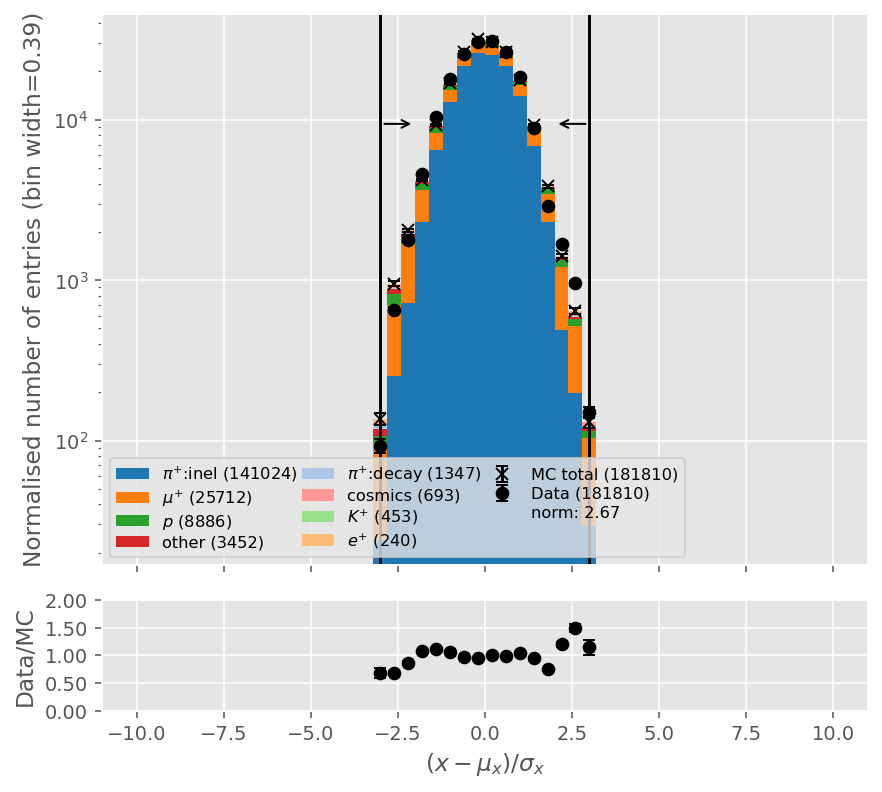

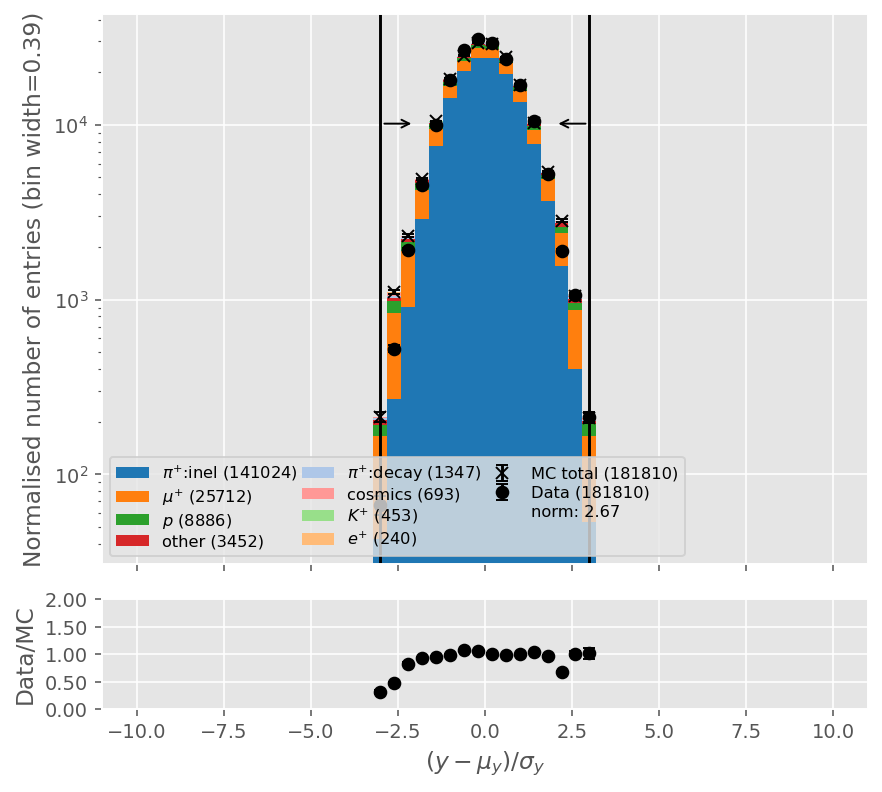

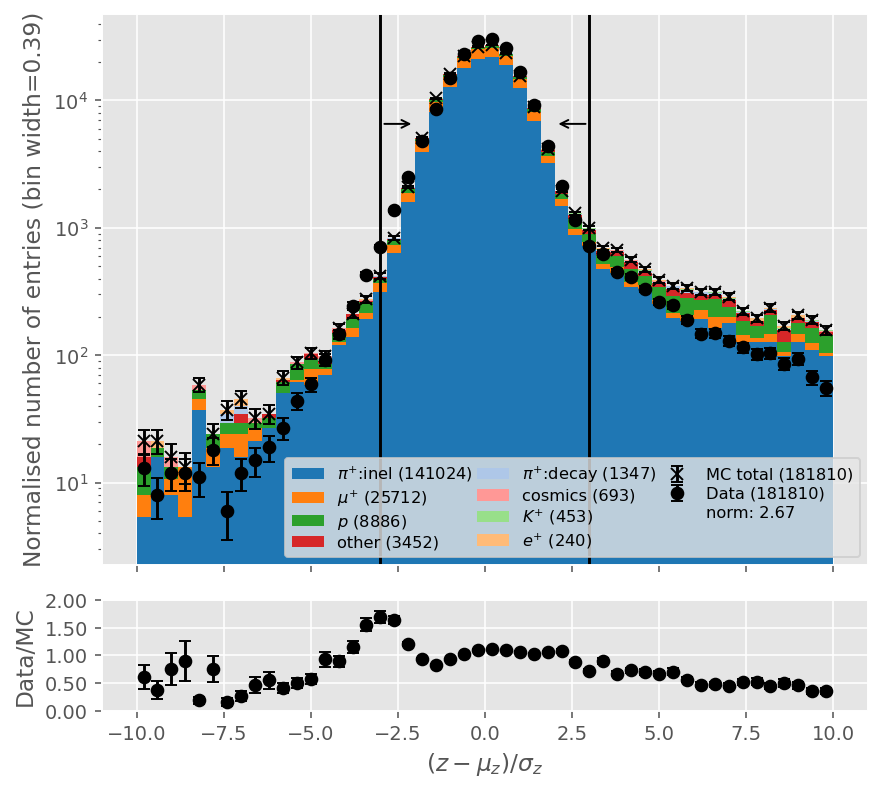

In [25]:
deltas_mc = {}
deltas_data = {}
for i in ["x", "y", "z"]:
    deltas_mc[i] = norm(samples["mc"].recoParticles.beam_startPos_SCE[i], beam_quality_fits["mc"][f"mu_{i}"], beam_quality_fits["mc"][f"sigma_{i}"])
    deltas_data[i] = norm(samples["data"].recoParticles.beam_startPos_SCE[i], beam_quality_fits["data"][f"mu_{i}"], beam_quality_fits["data"][f"sigma_{i}"])
    Plots.PlotTagged(deltas_mc[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(deltas_data[i]), bins = 50, x_range = [-10, 10], y_scale = "log", x_label = f"$(" + i + "- \mu_{"+ i + "} )/ \sigma_{" + i + "}$", ncols = 3, norm = True)
    Plots.DrawCutPosition(-3, arrow_length = 1, face = "right")
    Plots.DrawCutPosition(3, arrow_length = 1, face = "left")


masks = {
    "mc" : (deltas_mc["z"] > -3) & (deltas_mc["z"] < 3),
    "data" : (deltas_data["z"] > -3) & (deltas_data["z"] < 3)
}

FilterSamples(samples, masks)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


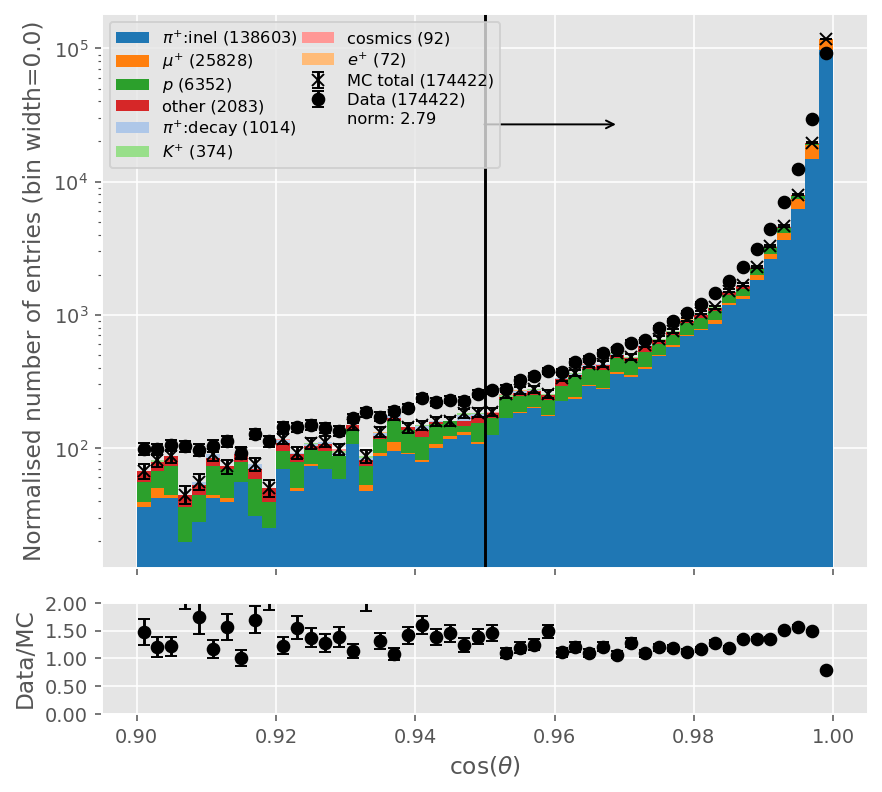

In [28]:
beam_dir = {s : vector.normalize(vector.sub(samples[s].recoParticles.beam_endPos_SCE, samples[s].recoParticles.beam_startPos_SCE)) for s in samples}

beam_dir_mu = {s : vector.normalize(vector.vector(beam_quality_fits[s]["mu_dir_x"], beam_quality_fits[s]["mu_dir_y"], beam_quality_fits[s]["mu_dir_z"])) for s in beam_quality_fits}

beam_costh = {s : vector.dot(beam_dir[s], beam_dir_mu[s]) for s in beam_dir_mu}

Plots.PlotTagged(beam_costh["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(beam_costh["data"]), x_label = "$\cos(\\theta)$", y_scale = "log", bins = 50, x_range = [0.9, 1], norm = True)
Plots.DrawCutPosition(0.95, arrow_length = 0.02)

masks = {s : beam_costh[s] > 0.95 for s in samples}
FilterSamples(samples, masks)

number of entries before|after APA3Cut: 59985|48795
number of entries before|after APA3Cut: 162761|124320


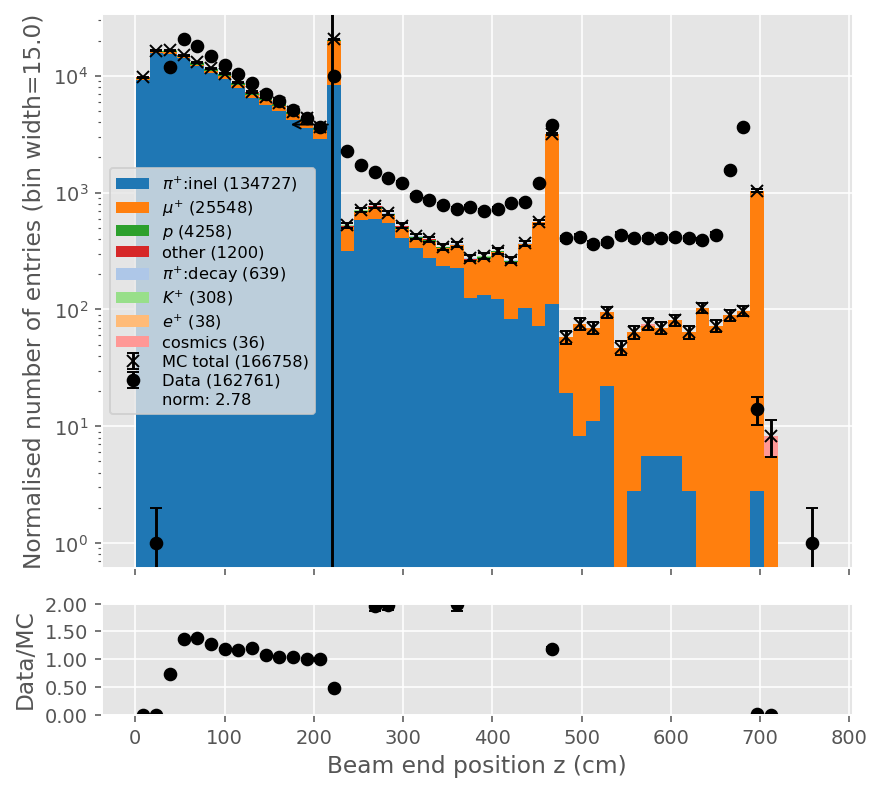

In [30]:
Plots.PlotTagged(samples["mc"].recoParticles.beam_endPos_SCE.z, Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.beam_endPos.z, x_label = "Beam end position z (cm)", norm = args.norm, bins = 50, y_scale = "log", ncols = 1)
Plots.DrawCutPosition(220, face = "left", arrow_length = 50)

masks = {s : BeamParticleSelection.APA3Cut(samples[s]) for s in samples}

FilterSamples(samples, masks)

number of entries before|after MichelScoreCut: 48795|48575
number of entries before|after MichelScoreCut: 124320|123883


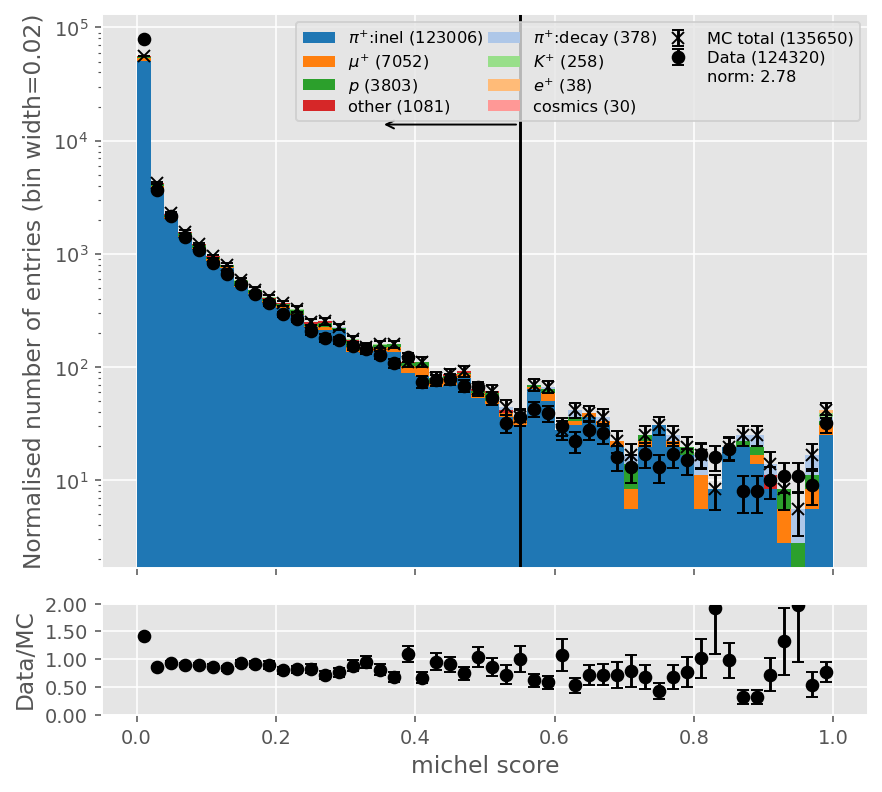

In [32]:
# michel score cut

scores = {}
for s in samples:
    score = ak.where(samples[s].recoParticles.beam_nHits != 0, samples[s].recoParticles.beam_michelScore / samples[s].recoParticles.beam_nHits, -999)
    masks[s] = BeamParticleSelection.MichelScoreCut(samples[s])
    scores[s] = score

Plots.PlotTagged(scores["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = np.array(scores["data"]), x_range = (0, 1), y_scale = "log", bins = 50, x_label = "michel score", ncols = 3, norm = args.norm)
Plots.DrawCutPosition(0.55, face = "left")

FilterSamples(samples, masks)

number of entries before|after MedianDEdXCut: 48575|46726
number of entries before|after MedianDEdXCut: 123883|117662


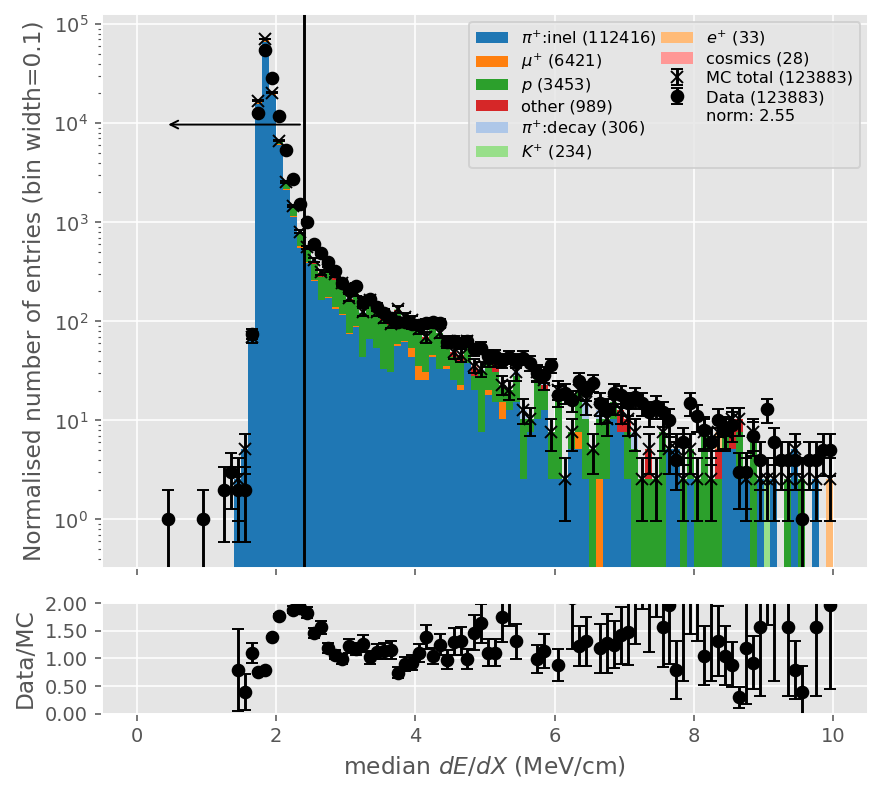

In [34]:
median = {s : PFOSelection.Median(samples[s].recoParticles.beam_dEdX) for s in samples}

Plots.PlotTagged(median["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = median["data"], y_scale = "log", x_range = [0, 10], x_label = "median $dE/dX$ (MeV/cm)", norm = True)
Plots.DrawCutPosition(2.4, face = "left", arrow_length = 2)

masks = {s : BeamParticleSelection.MedianDEdXCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

In [75]:
beam_inst_KE = cross_section.KE(mc.recoParticles.beam_inst_P, Particle.from_pdgid(211).mass) # get kinetic energy from beam instrumentation

true_ff_ind = ak.argmax(mc.trueParticles.beam_traj_pos.z >= 0, -1, keepdims = True)
not_int_tpc = true_ff_ind == 0

pitches = ak.ravel(vector.dist(mc.trueParticles.beam_traj_pos[true_ff_ind], mc.trueParticles.beam_traj_pos[true_ff_ind + 1]))
first_KE = mc.trueParticles.beam_traj_KE[true_ff_ind]

true_ffKE = ak.ravel(cex_beam_scraper_fits.GetTrueFFKE(first_KE, pitches)) # get the true Kinetic energy as the front face of the TPC
delta_KE_upstream = beam_inst_KE - true_ffKE


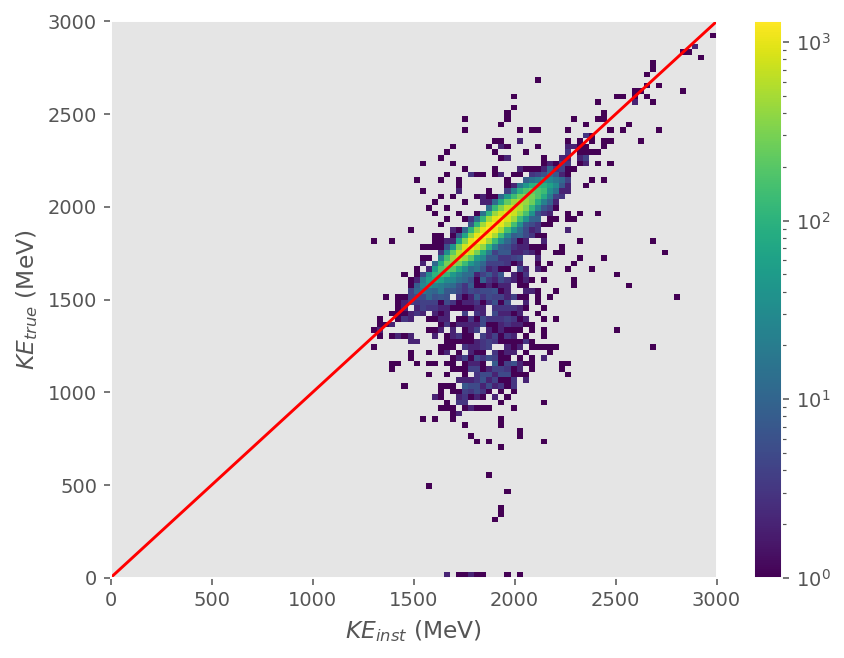

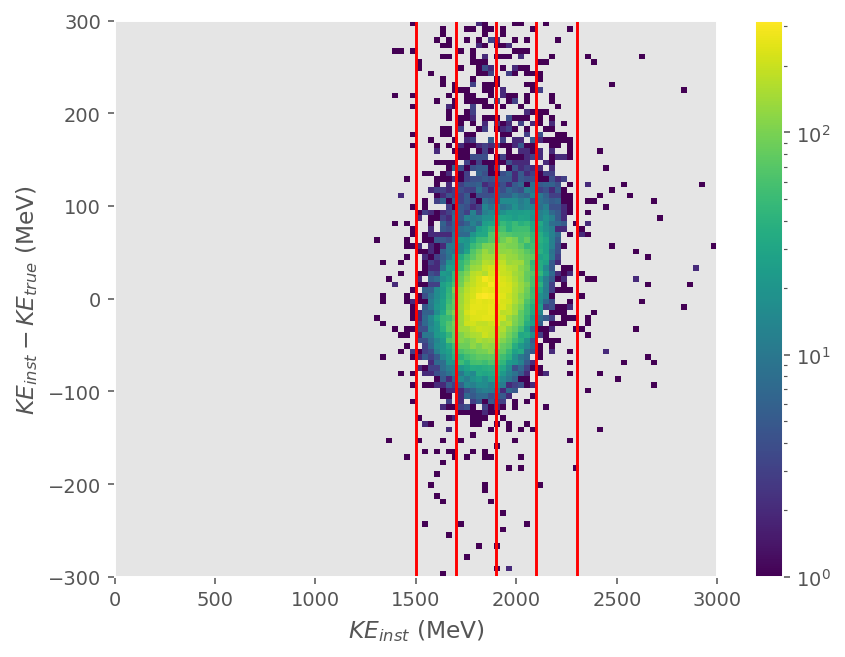

In [76]:
energy_range = [0, 3000]
residual_range = [-300, 300]
beam_inst_KE_bins = [1500, 1700, 1900, 2100, 2300]

bins = 100
multiplicity = 1.5

Plots.Plot(energy_range, energy_range, color = "red")
Plots.PlotHist2D(beam_inst_KE, true_ffKE, xlabel = "$KE_{inst}$ (MeV)", ylabel = "$KE_{true}$ (MeV)", x_range = energy_range, y_range = energy_range, newFigure = False)

delta_KE_upstream = beam_inst_KE - true_ffKE
Plots.PlotHist2D(beam_inst_KE, delta_KE_upstream, xlabel = "$KE_{inst}$ (MeV)", ylabel = "$KE_{inst} - KE_{true}$ (MeV)", x_range = energy_range, y_range = residual_range)
for i in beam_inst_KE_bins: plt.axvline(i, color = "red")


AttributeError: module 'python.analysis.cross_section' has no attribute 'Fit_Gaussian'

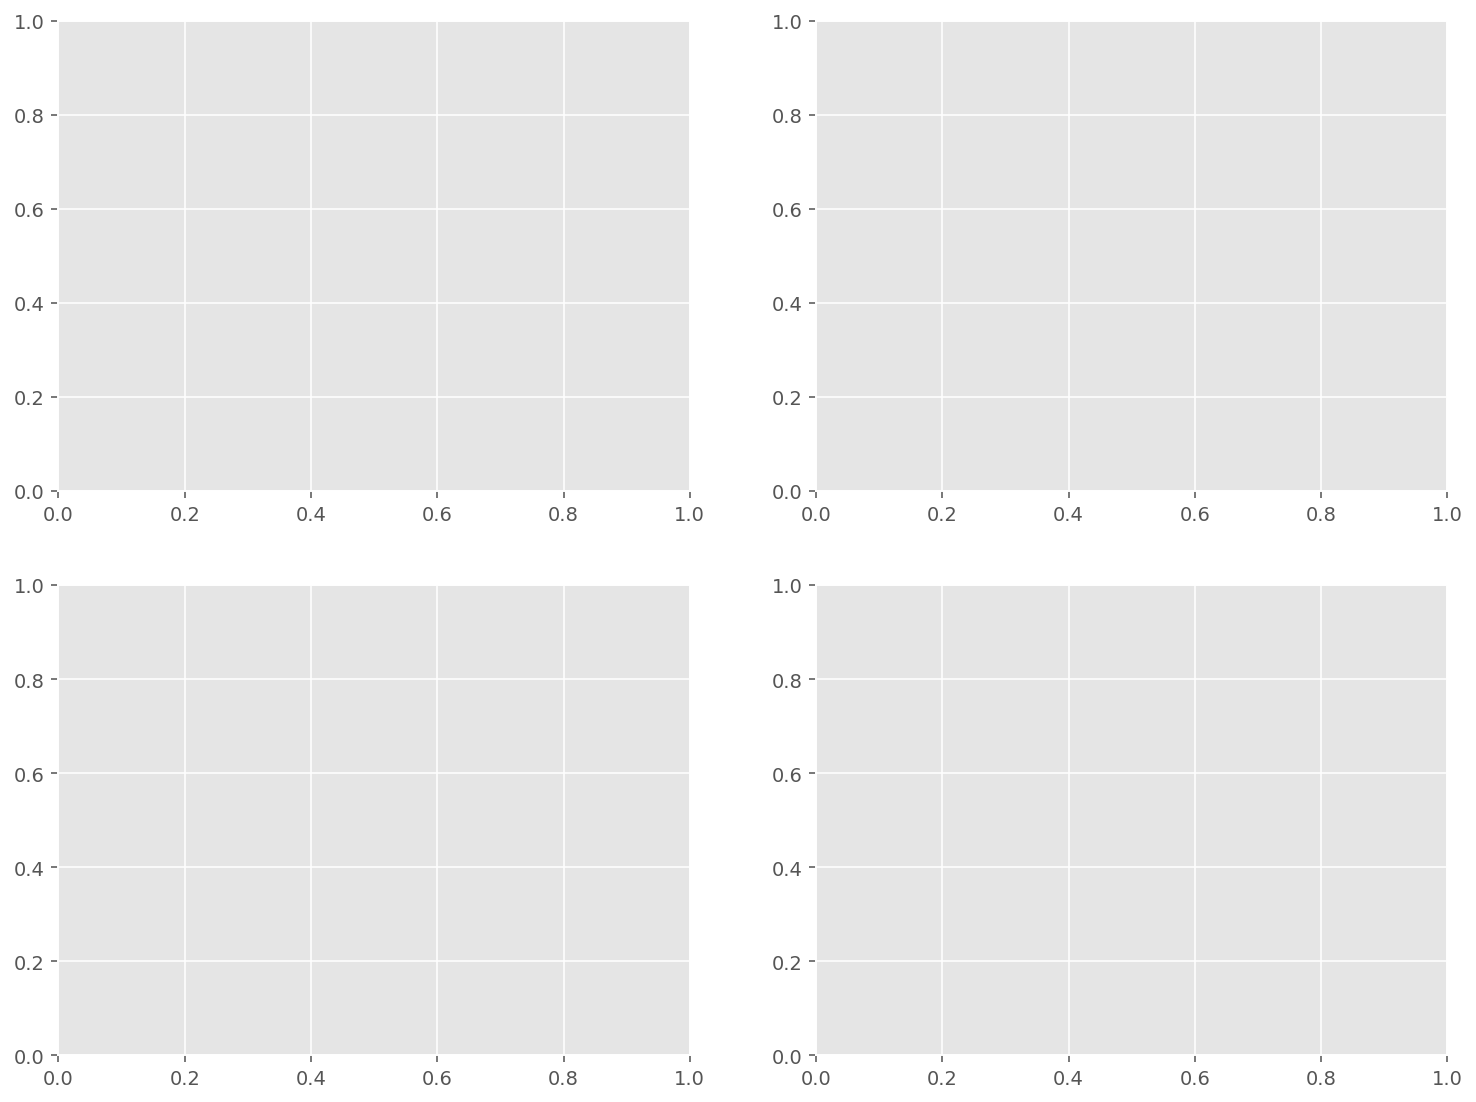

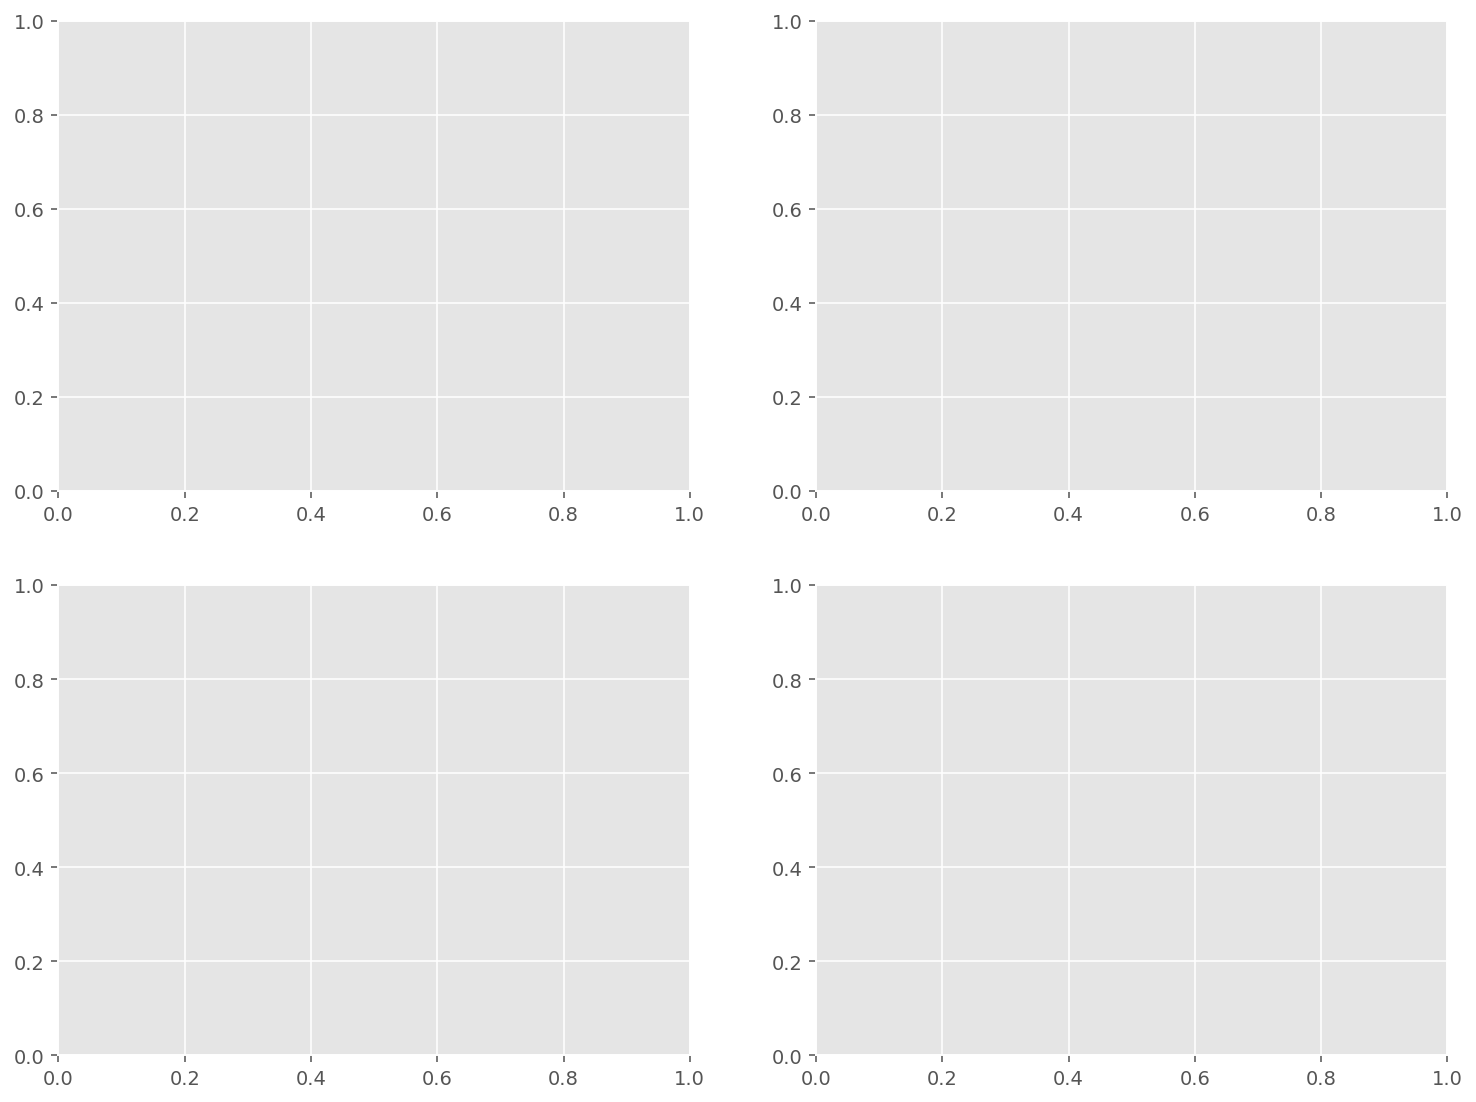

In [77]:
plt.subplots(2, 2, figsize = [6.4 * 2, 4.8 * 2], num = 1)
plt.gcf().set_size_inches(6.4 * 2, 4.8 * 2)

plt.subplots(2, 2, figsize = [6.4 * 2, 4.8 * 2], num = 2)
plt.gcf().set_size_inches(6.4 * 2, 4.8 * 2)

mean_x = []
mean_y = []
std_x = []
std_y = []

scraper_threshold = []

for i in range(1, len(beam_inst_KE_bins)):
    bin_label = "$KE_{inst}$:" + f"[{beam_inst_KE_bins[i-1]},{beam_inst_KE_bins[i]}] (MeV)"
    e = (beam_inst_KE < beam_inst_KE_bins[i]) & (beam_inst_KE > beam_inst_KE_bins[i-1])

    popt, pcov = cross_section.Fit_Gaussian(delta_KE_upstream[e], bins)
    print(popt, pcov)

    plt.figure(1)
    plt.subplot(2, 2, i)
    heights, edges = Plots.PlotHist(delta_KE_upstream[e], newFigure = False, bins = bins, range = residual_range)

    x_interp = np.linspace(min(delta_KE_upstream[e]), max(delta_KE_upstream[e]), 5 * bins)
    y_interp = cross_section.Gaussian(x_interp, max(heights), popt[1], popt[2])
    Plots.Plot(x_interp, y_interp, color = "red", label = "fit", title = bin_label, xlabel = "$KE_{inst} - KE_{true}$ (MeV)", newFigure = False)
    plt.axvline(popt[1] + 3 * abs(popt[2]), color = "black", linestyle = "--")
    plt.xlim(*residual_range)

    scraper_threshold.append(popt[1])
    is_scraper = delta_KE_upstream[e] > (popt[1] + 3 * abs(popt[2]))

    plt.figure(2)
    plt.subplot(2, 2, i)
    Plots.Plot(mc.recoParticles.beam_inst_pos.x[e][~is_scraper], mc.recoParticles.beam_inst_pos.y[e][~is_scraper], newFigure = False, linestyle = "", marker = "o", markersize = 2, title = bin_label, color = "C0", alpha = 0.5, label = "non-scraper")
    Plots.Plot(mc.recoParticles.beam_inst_pos.x[e][is_scraper], mc.recoParticles.beam_inst_pos.y[e][is_scraper], newFigure = False, linestyle = "", marker = "o", markersize = 2, title = bin_label, color = "C6", alpha = 0.5, label = "scraper")
    plt.xlabel("$X_{inst}$ (cm)")
    plt.ylabel("$Y_{inst}$ (cm)")

    mu_x = ak.mean(mc.recoParticles.beam_inst_pos[e].x)
    mu_y = ak.mean(mc.recoParticles.beam_inst_pos[e].y)
    sigma_x = ak.std(mc.recoParticles.beam_inst_pos[e].x)
    sigma_y = ak.std(mc.recoParticles.beam_inst_pos[e].y)


    theta = np.linspace(0, 2*np.pi, 100)
    r = multiplicity * (sigma_x**2 + sigma_y**2)**0.5
    x = r*np.cos(theta) + mu_x
    y = r*np.sin(theta) + mu_y
    
    plt.plot(x, y, linestyle = "--", color = "black", label = "cut", zorder = 10)
    plt.axis('scaled')
    plt.legend()

    mean_x.append(mu_x)
    mean_y.append(mu_y)
    std_x.append(sigma_x)
    std_y.append(sigma_y)

print(mean_x[1])
print(mean_y[1])
print(std_x[1])
print(std_y[1])
print(scraper_threshold)


mu or sigma was not specified, manually calculating beam scraper cut values
[0.0549, 1.53, -0.555, 0.151, -0.469, -2.28, ... 0.767, 1.24, 0.241, 1.01, -0.273]
[-0.321, -1.01, 0.0951, -1.11, -1.25, ... -0.608, 0.199, 0.529, -0.319, 0.702]
number of entries before|after BeamScraper: 77632|57620


57620

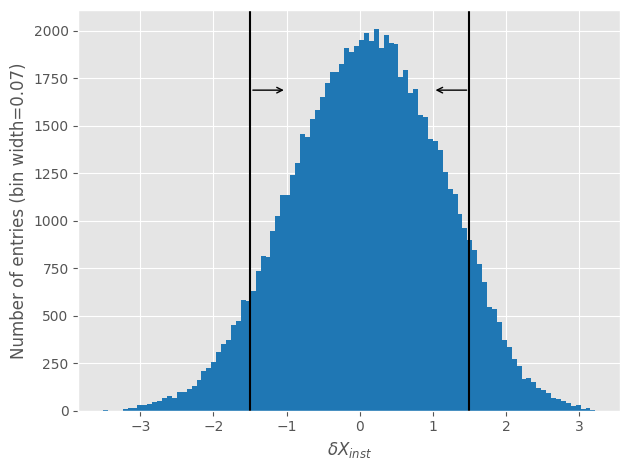

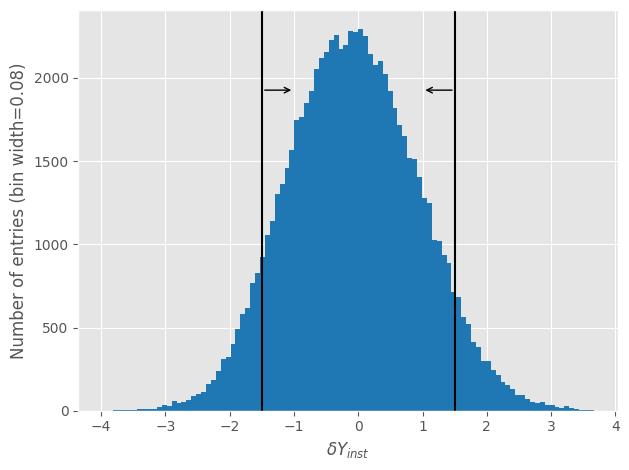

In [19]:
nx = norm(mc.recoParticles.beam_inst_pos.x, mean_x[1], std_x[1])
ny = norm(mc.recoParticles.beam_inst_pos.y, mean_y[1], std_y[1])

mc_mask = BeamParticleSelection.BeamScraper(mc, KE_range = [800, 900])

print(ak.sum(mc_mask))

r = (nx**2 + ny**2)**0.5
Plots.PlotHist(nx, xlabel = "$\delta X_{inst}$")
Plots.DrawCutPosition(-multiplicity, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(multiplicity, arrow_length = 0.5, face = "left")

Plots.PlotHist(ny, xlabel = "$\delta Y_{inst}$")
Plots.DrawCutPosition(-multiplicity, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(multiplicity, arrow_length = 0.5, face = "left")


# Quick Beam Selection

In [3]:
masks = {}
masks["mc"] = BeamParticleSelection.CreateDefaultSelection(samples["mc"], False, beam_quality_fits["mc"], verbose = False, return_table = False)
masks["data"] = BeamParticleSelection.CreateDefaultSelection(samples["data"], True, beam_quality_fits["data"], verbose = False, return_table = False)
FilterSamples(samples, masks)

masks = {s : PFOSelection.GoodShowerSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after PiBeamSelection: 141548|102443
number of entries before|after PandoraTagCut: 141548|123438
number of entries before|after CaloSizeCut: 141548|125589


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 141548|115682
number of entries before|after BeamQualityCut: 141548|82069
number of entries before|after APA3Cut: 141548|120483
number of entries before|after MedianDEdXCut: 141548|131247
number of entries before|after PiBeamSelection: 1349399|285238
number of entries before|after PandoraTagCut: 1349399|508203
number of entries before|after CaloSizeCut: 1349399|587932
number of entries before|after MichelScoreCut: 1349399|496543
number of entries before|after BeamQualityCut: 1349399|273698
number of entries before|after APA3Cut: 1349399|1263147
number of entries before|after MedianDEdXCut: 1349399|1295793


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


number of entries before|after ValidRecoPositionCut: 171337|164109
number of entries before|after ValidRecoMomentumCut: 171337|152487
number of entries before|after ValidRecoEnergyCut: 171337|152487
number of entries before|after ValidRecoPositionCut: 449545|428273
number of entries before|after ValidRecoMomentumCut: 449545|396782
number of entries before|after ValidRecoEnergyCut: 449545|396782


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply fil

# $\pi^{+}$ Particle Selection

number of entries before|after BeamDaughterCut: 46519|0
number of entries before|after BeamDaughterCut: 117240|0


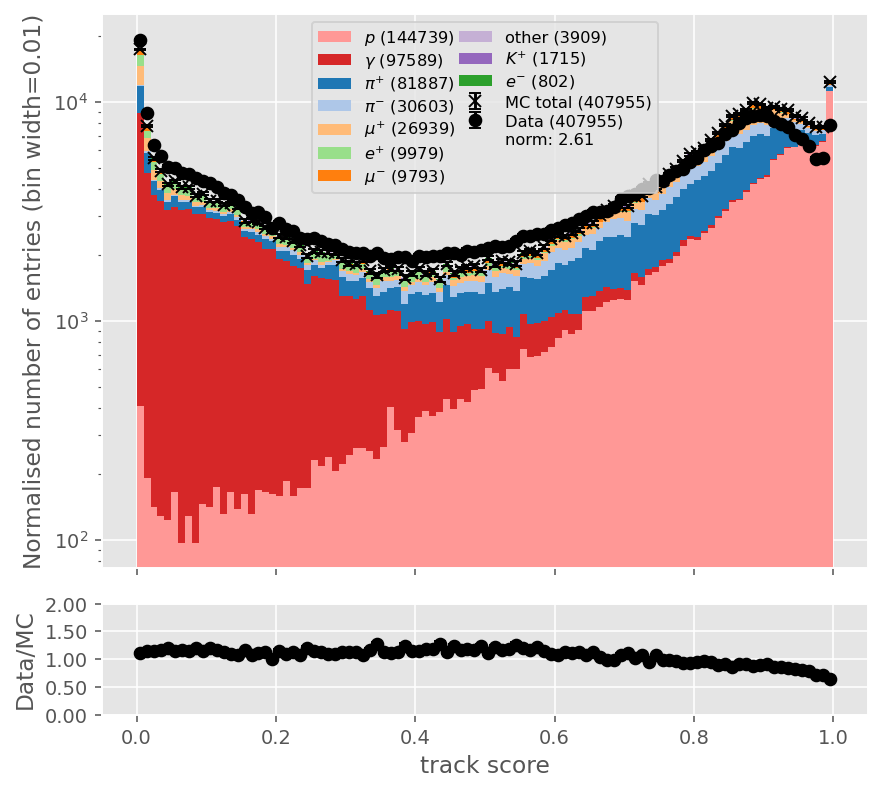

In [4]:
# only for my ntuples
masks = {s : PFOSelection.BeamDaughterCut(samples[s]) for s in samples}
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "log", x_label = "track score", norm = True)


number of entries before|after TrackScoreCut: 156355|100379
number of entries before|after TrackScoreCut: 408436|241511


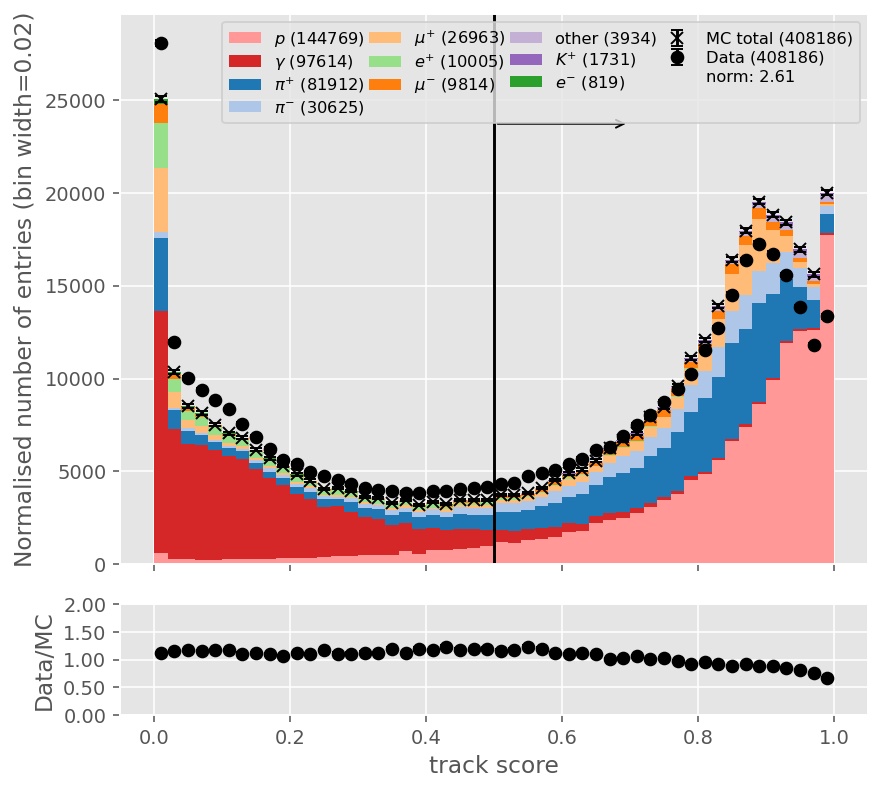

In [4]:
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "linear", bins = 50, ncols = 4, x_label = "track score", norm = True)
Plots.DrawCutPosition(0.5, face = "right")

masks = {s : PFOSelection.TrackScoreCut(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after NHitsCut: 100379|94725
number of entries before|after NHitsCut: 241511|227140


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb1616

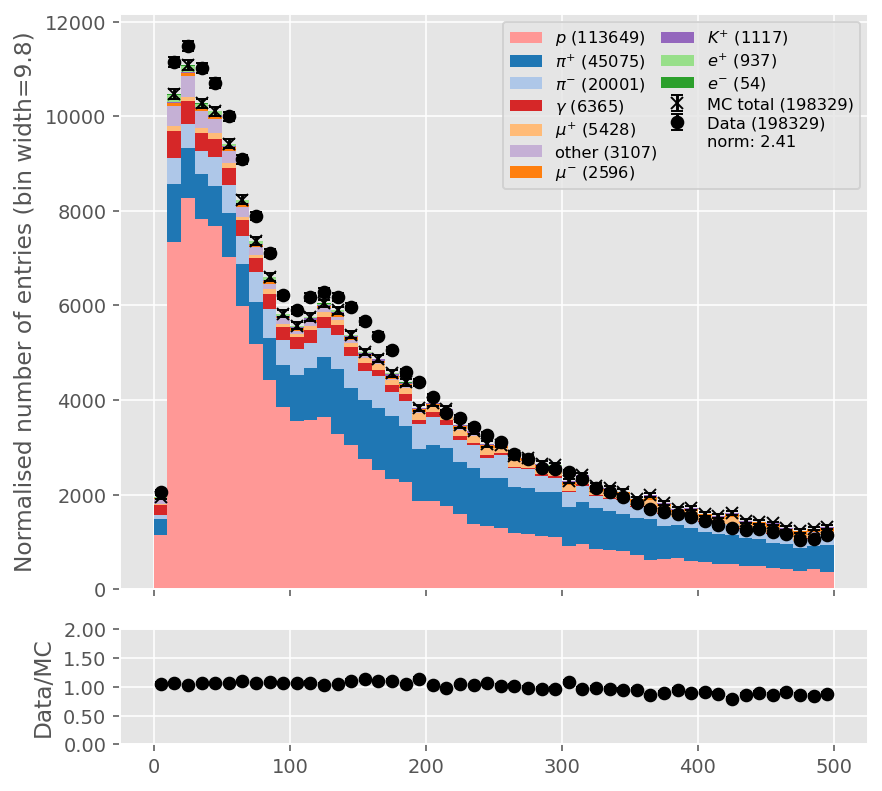

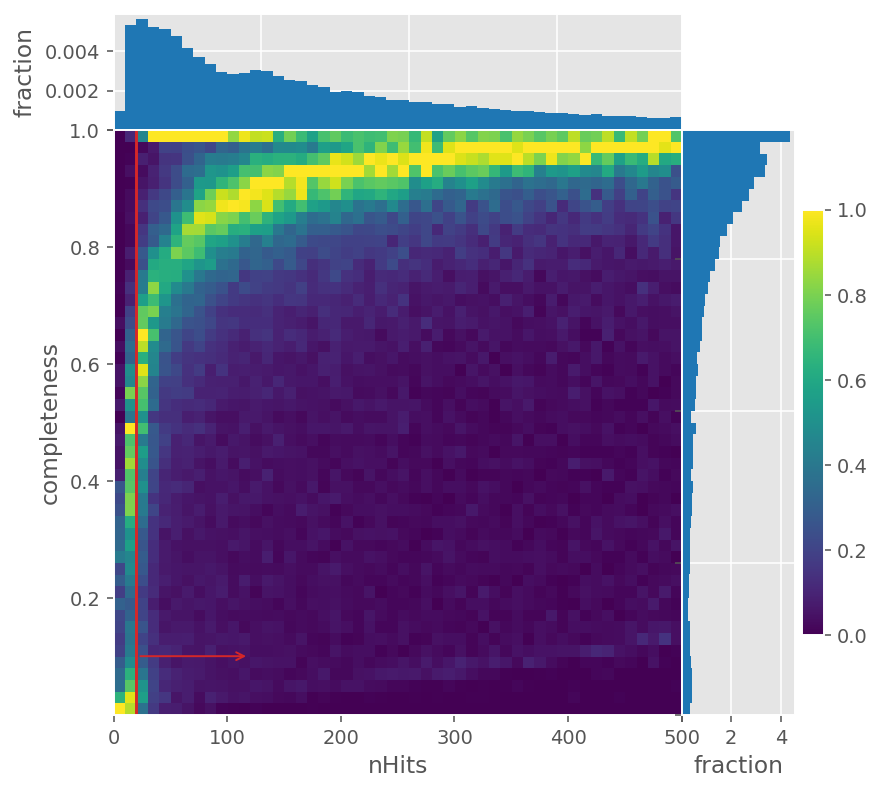

In [12]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, ncols = 2, x_range = [0, 500], norm = True)
# Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(samples["mc"].recoParticles.nHits), xlabel = "completeness", ylabel = "nHits", y_range = [0, 500], bins = 50)

Plots.PlotHist2DImshowMarginal(ak.ravel(samples["mc"].recoParticles.nHits), ak.ravel(samples["mc"].trueParticlesBT.completeness), ylabel = "completeness", xlabel = "nHits", x_range = [0, 500], bins = 50, norm = "column", c_scale = "linear")
Plots.DrawCutPosition(20, arrow_length = 100, arrow_loc = 0.1, color = "C6")

masks = {s : PFOSelection.NHitsCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1171: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1172: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)


number of entries before|after PiPlusSelection: 94725|45586
number of entries before|after PiPlusSelection: 227140|104789


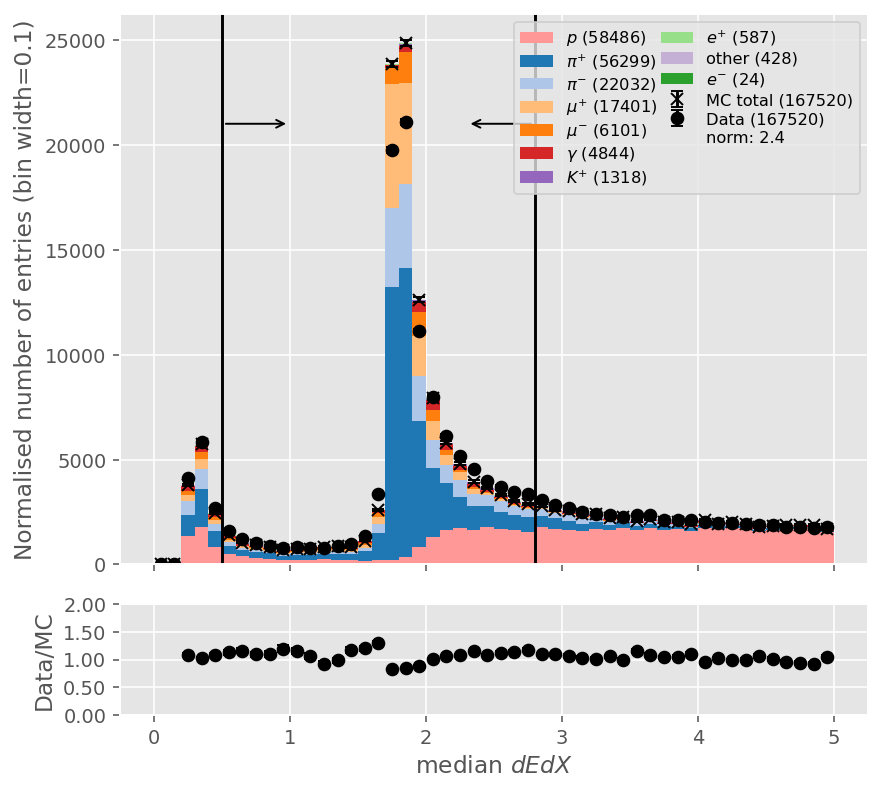

In [13]:
median_dEdX = {s : PFOSelection.Median(samples[s].recoParticles.track_dEdX) for s in samples}
Plots.PlotTagged(median_dEdX["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = median_dEdX["data"], ncols = 2, x_range = [0, 5], x_label = "median $dEdX$", bins = 50, norm = True)

Plots.DrawCutPosition(0.5, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(2.8, arrow_length = 0.5, face = "left")

masks = {s : PFOSelection.PiPlusSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [310, 1285, 6731, 2205, 20268, 7211, 162, 7, 7337, 70])

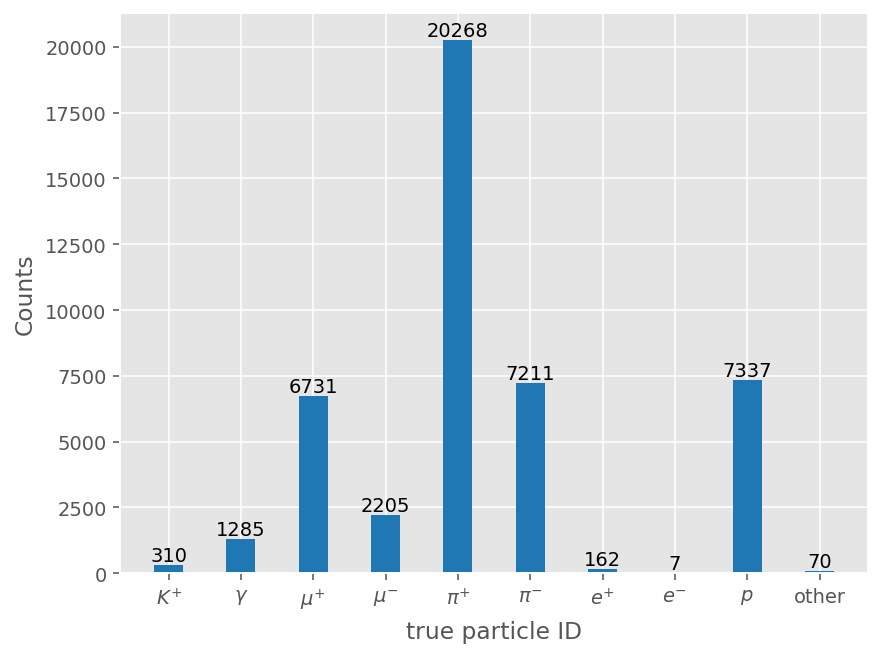

In [22]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")


# photon candidate selection

number of entries before|after EMScoreCut: 152487|54227
number of entries before|after EMScoreCut: 396782|160877


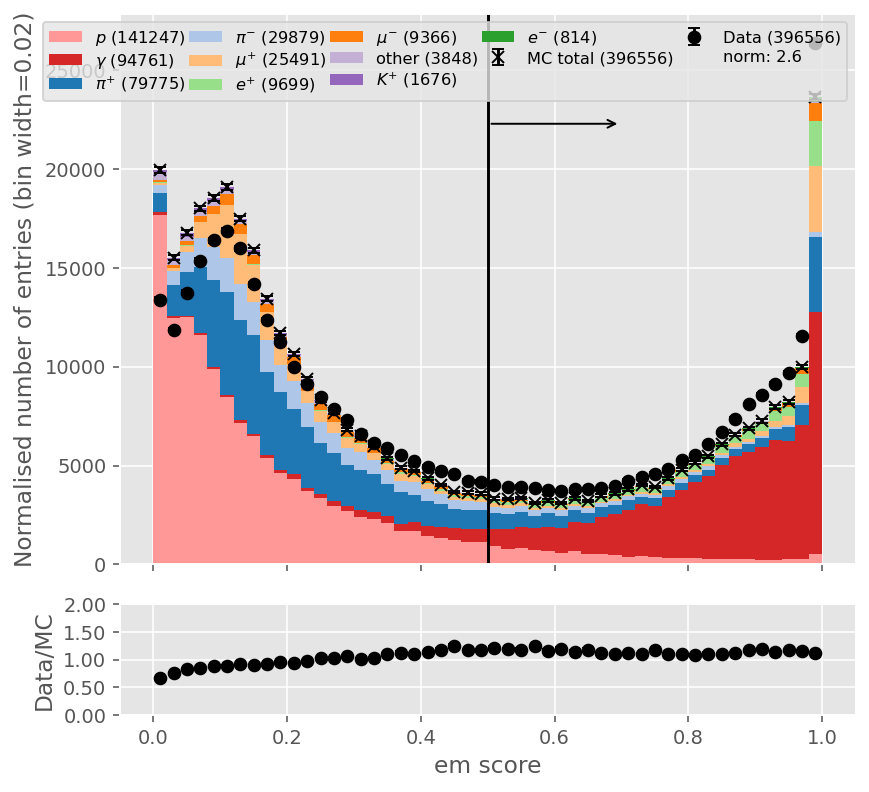

In [7]:
Plots.PlotTagged(samples["mc"].recoParticles.emScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.emScore, bins = 50, x_range = [0, 1], ncols = 5, x_label = "em score", norm = True)
Plots.DrawCutPosition(0.5)

masks = {s : PFOSelection.EMScoreCut(samples[s], 0.5) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after NHitsCut: 54227|28501
number of entries before|after NHitsCut: 160877|87254


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb

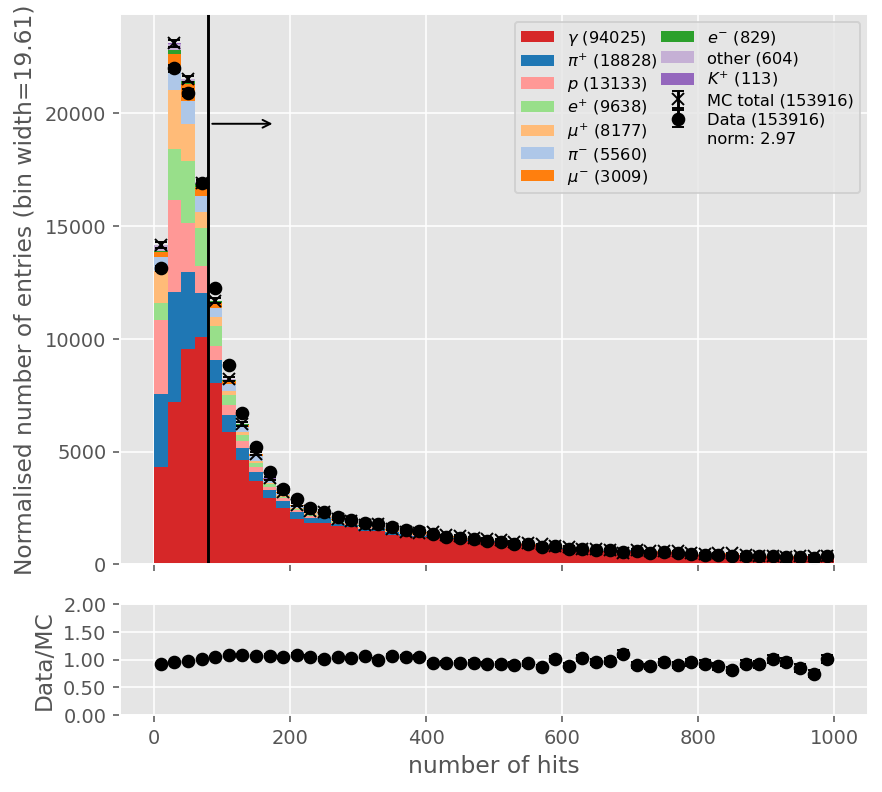

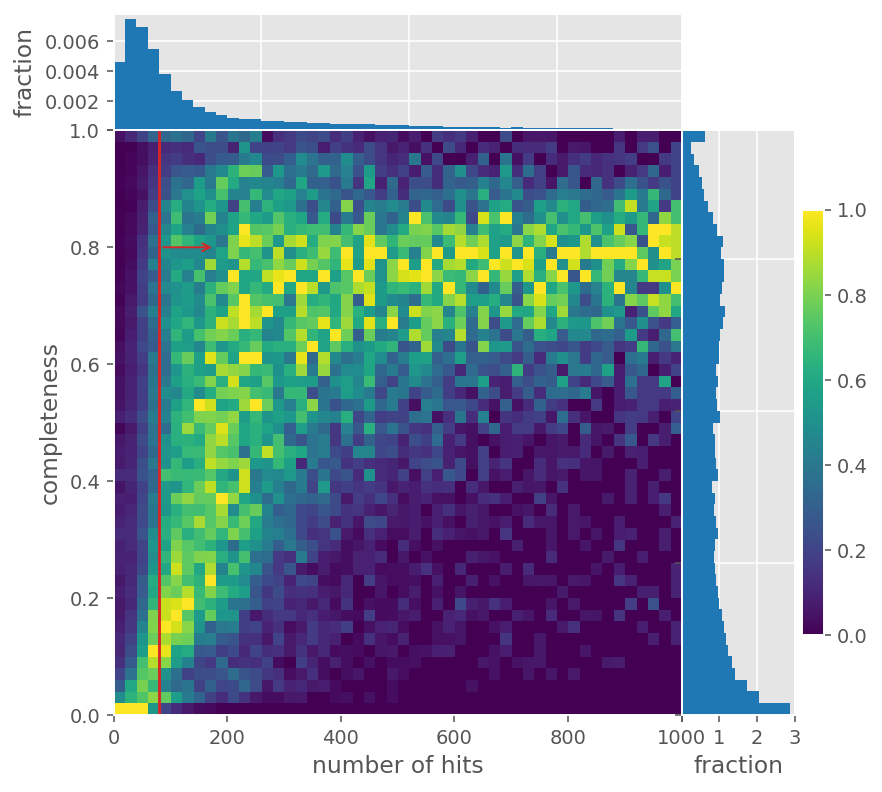

In [10]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, x_label = "number of hits", x_range = [0, 1000], norm = True)
Plots.DrawCutPosition(80, arrow_length = 100)

Plots.PlotHist2DImshowMarginal(ak.ravel(samples["mc"].recoParticles.nHits), ak.ravel(samples["mc"].trueParticlesBT.completeness), bins = 50, y_range = [0, 1],x_range = [0, 1000], ylabel = "completeness", xlabel = "number of hits", norm = "column")
Plots.DrawCutPosition(80, flip = False, arrow_length = 100, color = "C6")

masks = {s : PFOSelection.NHitsCut(samples[s], 80) for s in samples}
FilterSamples(samples, masks, True)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1171: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1172: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python

number of entries before|after BeamParticleDistanceCut: 23084|23084
number of entries before|after BeamParticleDistanceCut: 72140|72140


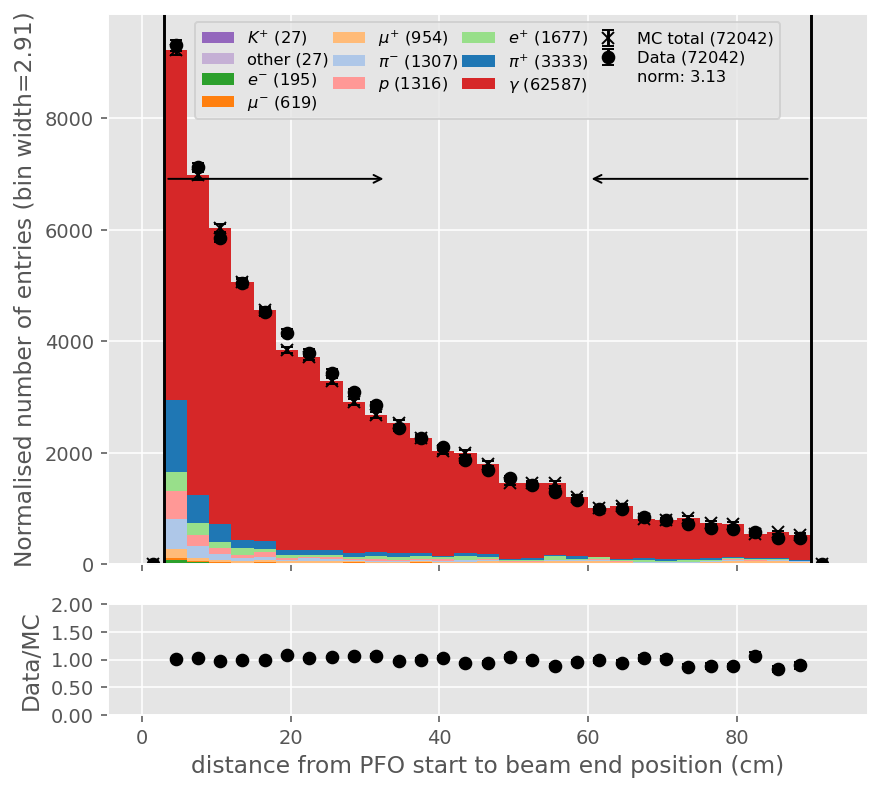

In [23]:
dist = {s : vector.dist(samples[s].recoParticles.startPos, samples[s].recoParticles.beam_endPos) for s in samples}

Plots.PlotTagged(dist["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = dist["data"], bins = 31, x_range = [0, 93], x_label = "distance from PFO start to beam end position (cm)", ncols = 4, norm = True, stacked = "ascending", truncate = True)
Plots.DrawCutPosition(3, arrow_length = 30, arrow_loc = 0.7)
Plots.DrawCutPosition(90, face = "left", arrow_length = 30, arrow_loc = 0.7)

masks = {s : PFOSelection.BeamParticleDistanceCut(samples[s], [3, 90]) for s in samples}
FilterSamples(samples, masks, True)

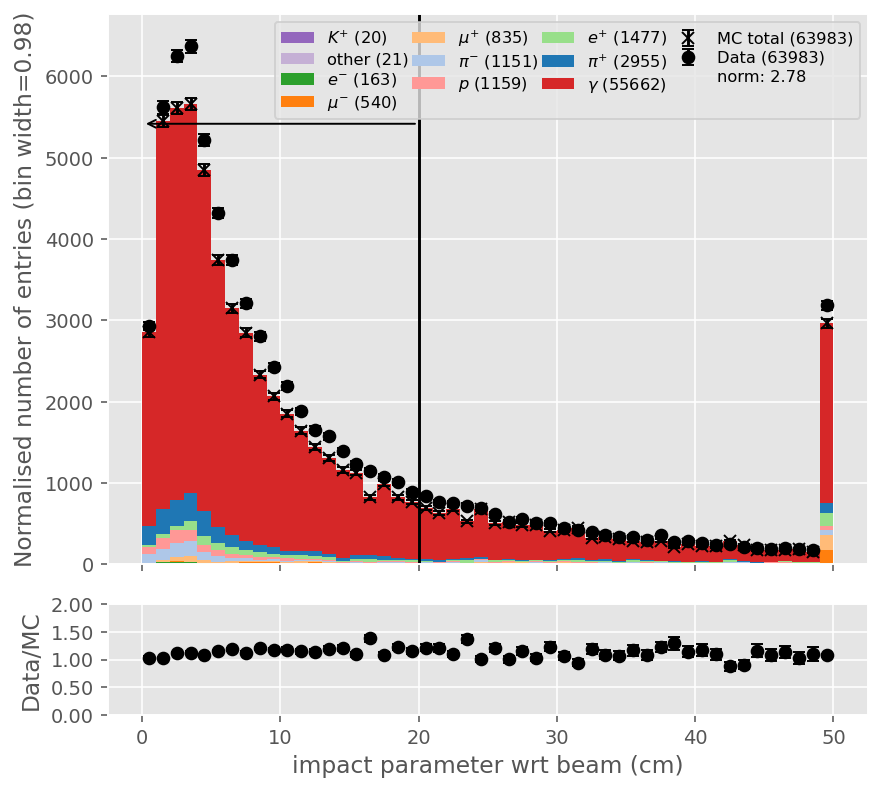

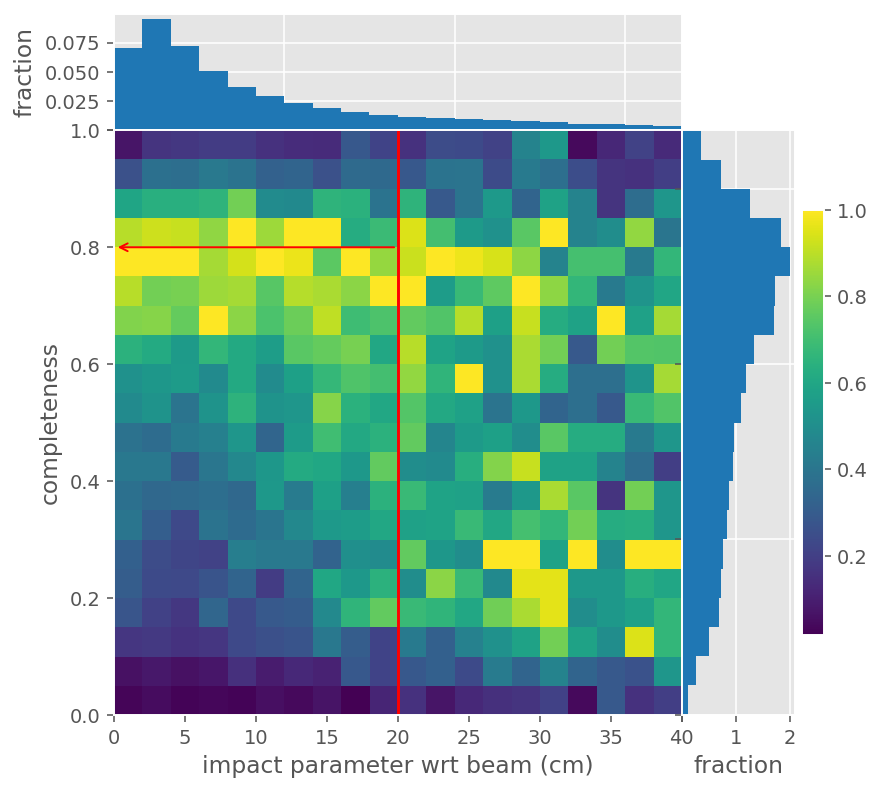

In [24]:
ip = {s : PFOSelection.find_beam_impact_parameters(samples[s]) for s in samples}

Plots.PlotTagged(ip["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = ip["data"], x_range = [0, 50], bins = 50, x_label = "impact parameter wrt beam (cm)", norm = args.norm, stacked = "ascending", ncols = 4, truncate = True)
Plots.DrawCutPosition(20, arrow_length = 20, face = "left")

Plots.PlotHist2DImshowMarginal(ak.ravel(ip["mc"]), ak.ravel(samples["mc"].trueParticlesBT.completeness), x_range = [0, 40], y_range = [0, 1], bins = 20, norm = "column", c_scale = "linear", ylabel = "completeness", xlabel = "impact parameter wrt beam (cm)")
Plots.DrawCutPosition(20, arrow_length = 20, face = "left", color = "red")

# masks = {s : PFOSelection.BeamParticleIPCut(samples[s], 20) for s in samples}
# FilterSamples(samples, masks, True)


(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [13, 13905, 159, 58, 1140, 411, 331, 53, 495, 9])

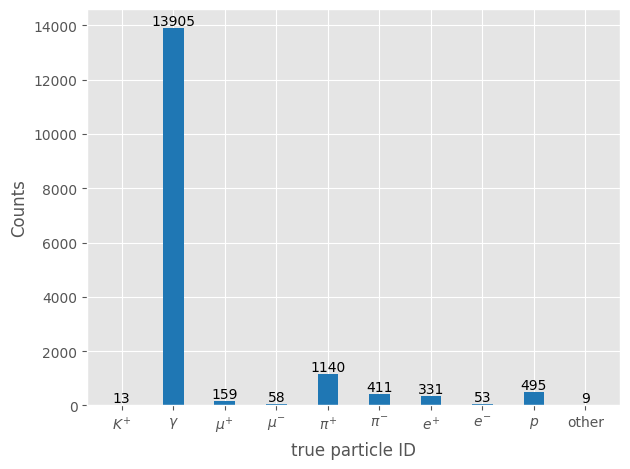

In [9]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")

# $\pi^{0}$ selection

In [4]:
photonCandidates = {s : PFOSelection.InitialPi0PhotonSelection(samples[s]) for s in samples}


number of entries before|after EMScoreCut: 152487|54227
number of entries before|after NHitsCut: 152487|98374
number of entries before|after BeamParticleDistanceCut: 152487|81792
number of entries before|after BeamParticleIPCut: 152487|122678
number of entries before|after VetoBeamParticle: 152487|152487
number of entries before|after EMScoreCut: 396782|160877
number of entries before|after NHitsCut: 396782|250469
number of entries before|after BeamParticleDistanceCut: 396782|226888
number of entries before|after BeamParticleIPCut: 396782|321932
number of entries before|after VetoBeamParticle: 396782|396782


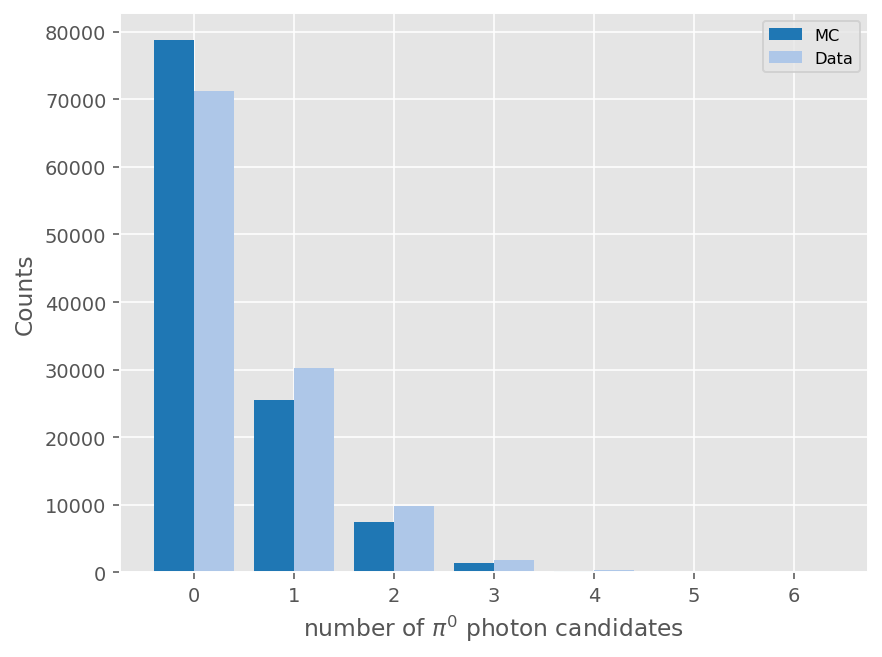

In [5]:
# n_photons = {s : ak.num(samples[s].recoParticles.number) for s in samples}

n_photons = {s : ak.sum(photonCandidates[s], -1) for s in samples}

scale = ak.count(n_photons["data"]) / ak.count(n_photons["mc"])

n_photons_scaled = []
u, c = np.unique(n_photons["mc"], return_counts = True)
for i, j in zip(u, c):
    n_photons_scaled.extend([i]* int(scale * j))

Plots.PlotBarComparision(n_photons_scaled, n_photons["data"], xlabel = "number of $\pi^{0}$ photon candidates", label_1 = "MC", label_2 = "Data", barlabel = False)

masks = {s : n_photons[s] == 2 for s in samples}
FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

# mask = n_photons == 2
# events.Filter([mask], [mask])

no truth information found, sorting showers by reco energy instead

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


some tags do not have colours, will override them for the default ones


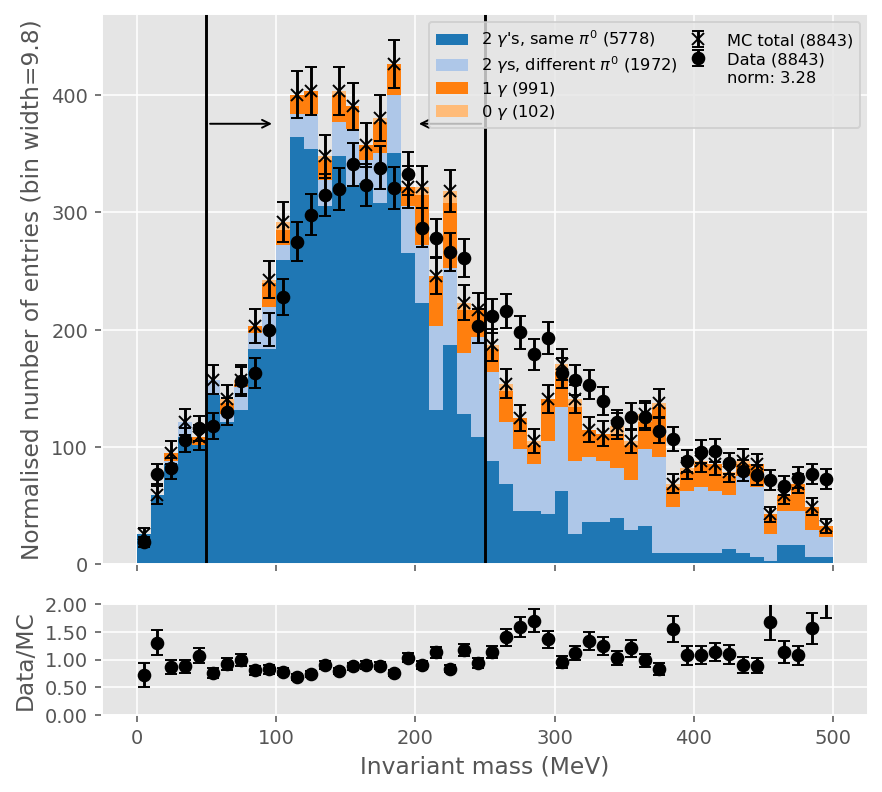

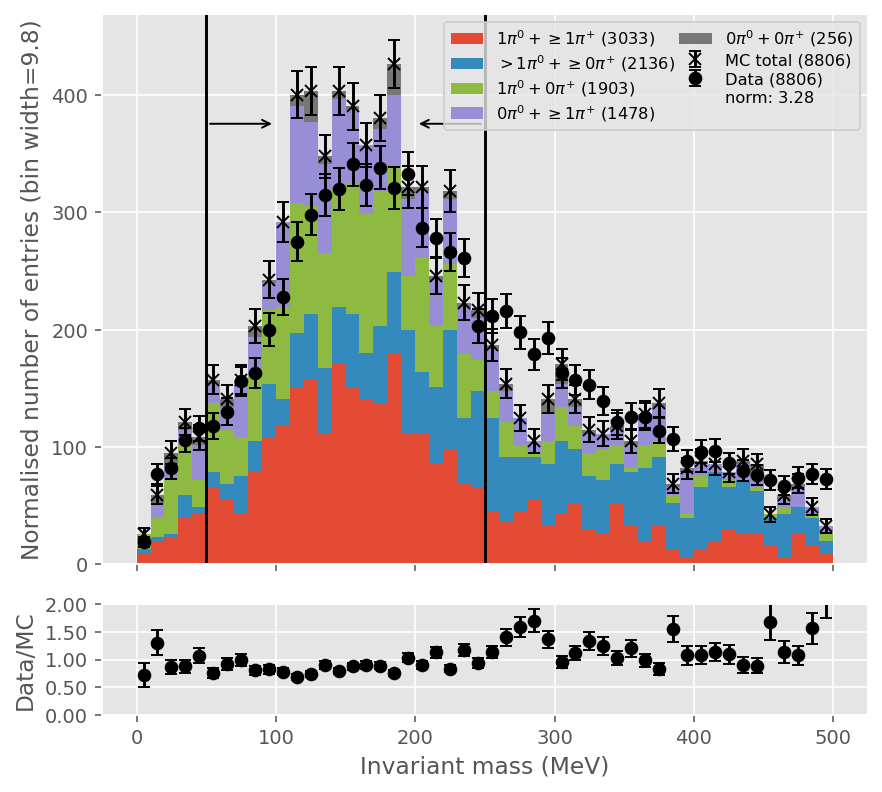

In [15]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

#* energy correction
correction_function = cross_section.EnergyCorrection.shower_energy_correction[args.correction]

with open(args.correction_params, "r") as f:
    correction_params = json.load(f)


# mass = {s : ak.flatten(shower_pairs[s].reco_mass) for s in samples}

e0 = {s : correction_function(shower_pairs[s].reco_lead_energy, **correction_params) for s in samples}
e1 = {s : correction_function(shower_pairs[s].reco_sub_energy, **correction_params) for s in samples}

mass = {s : Master.ShowerPairs.Mass(e0[s], e1[s], shower_pairs[s].reco_angle) for s in samples}


Plots.PlotTagged(mass["mc"], Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = mass["data"], bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

Plots.PlotTagged(mass["mc"], Tags.GenerateTrueFinalStateTags(samples["mc"]), data2 = mass["data"], bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

# FilterSamples(samples, masks)
# photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

no truth information found, sorting showers by reco energy instead

some tags do not have colours, will override them for the default ones


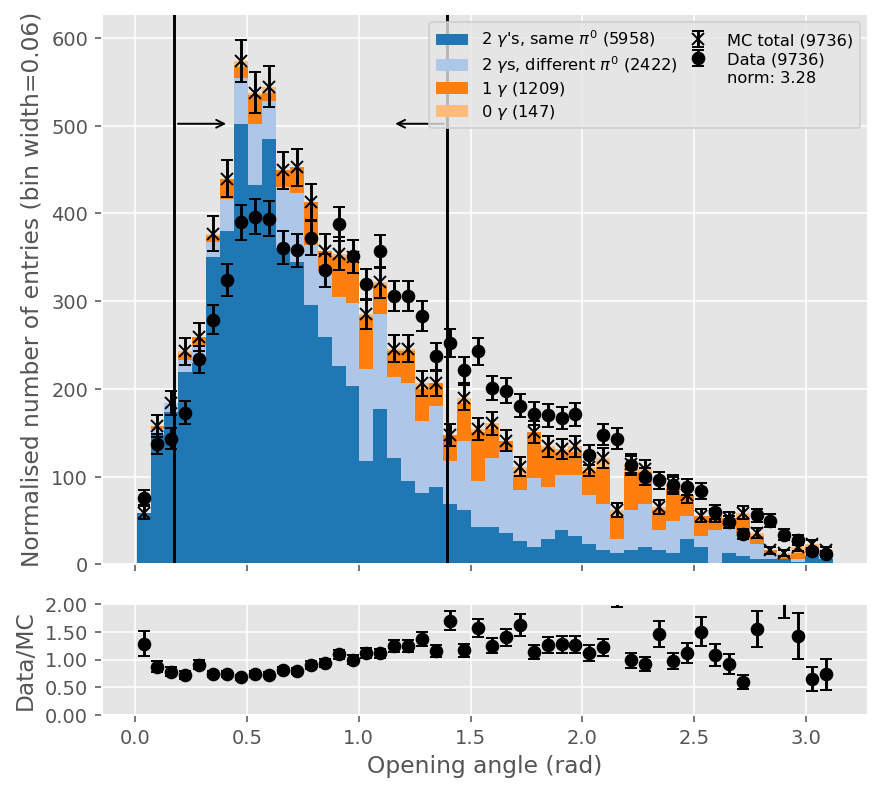

In [16]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

angle = {s : ak.flatten(shower_pairs[s].reco_angle) for s in samples}

Plots.PlotTagged(mass["mc"] / f, EventSelection.GenerateTrueFinalStateTags(samples["mc"]), data2 = mass["data"] / f, bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

masks = {s : (angle[s] > (10 * np.pi / 180)) & (angle[s] < (80 * np.pi / 180)) for s in samples}
# FilterSamples(samples, masks)
# photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

In [26]:
event_topology_tags = EventSelection.GenerateTrueFinalStateTags(samples["mc"])

for t in event_topology_tags:
    print(event_topology_tags[t].name_simple, ak.sum(event_topology_tags[t].mask), ak.count(event_topology_tags[t].mask))

exclusive signal 237 1921

background 350 1921

sideband 312 1921

sideband 904 1921

sideband 118 1921